COMP 4449: Capstone | Summer 2023

Midterm Project: Recognizing Traffic Signs

Sammantha Firestone

# Background
Autonomous vehicles have revolutionized the transporation industry, leveraging advance technology to navigate roads and make independent decisions. An essential aspect of autonomous driving is accurately detecting and classifying traffic signs, which provide critical information for safe and efficient driving. By correctly identifying traffic signs in real-life conditions, autonomous vehicles can comply with regulations and ensure the safety of passengers, other drivers, and pedestrians.

# Research Question
This project aims to develop a robust model capable of accurately identifying and classifying traffic signs in real-life images. By employing the deep learning technique of Convolutional Neural Networks (CNN), this project will explore the impact of various hyperparameters on the model's performance, and ultimately determine the optimal model for traffic sign recognition.

# Outline
* [Import Libraries](#Import-Libraries)
* [Download & Import Data](#Download-&-Import-Data)
* [Data Exploration](#Data-Exploration)
    * [Data Summary](#Data-Summary)
    * [Plotting Images](#Plotting-Images)
    * [Plotting All Classes of Images](#Plotting-All-Classes-of-Images)
    * [Plotting Pixel Intensity Distribution by Class](#Plotting-Pixel-Intensity-Distribution-by-Class)
    * [Plotting Number of Images per Class](#Plotting-Number-of-Images-per-Class)
* [Data Preprocessing](#Data-Preprocessing)
    * [Shuffle Data](#Shuffle-Data)
    * [Normalize Data](#Normalize-Data)
    * [Oversample Data](#Oversample-Data)
    * [One-Hot Encode Labels and Convert to Tensors](#One-Hot-Encode-Labels-and-Convert-to-Tensors)
* [Model Training](#Model-Training)
    * [Basic CNN Architecture](#Basic-CNN-Architecture)
    * [Basic CNN Model with Dropout Layers and Ridge Regularization](#Basic-CNN-Model-with-Dropout-and-Regularization)
    * [Basic LeNet5 Model](#Basic-LeNet5-Model)
    * [LeNet5 Model with Dropout Layers and Ridge Regularization](#LeNet5-Model-with-Dropout-and-Regularization)
* [Model Evaluation](#Model-Evaluation)
    * [Evaluate Model on Test Set](#Evaluate-Model-on-Test-Set)
    * [Confusion Matrix](#Confusion-Matrix)
    * [Plot Misclassified Images](#Plot-Misclassified-Images)
    * [Activation Heatmap](#Activation-Heatmap)
* [Conclusion](#Conclusion)


# Import Libraries
Many libraries are used throughout this project, however the most essential to creating the CNN model are:
* [TensorFlow](https://www.tensorflow.org/): an open-source machine learning library
* [Keras](https://keras.io/): a high-level neural networks API

In [1]:
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import timeit
import random

import pandas as pd
import pickle
import cv2
import skimage.morphology as morp
from skimage.filters import rank
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import L2
from tensorflow.keras import layers
from keras.utils import plot_model

# set random seed for all libraries for reproducible results
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# print versions of libraries
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("OpenCV version: ", cv2.__version__)

%matplotlib inline


Tensorflow version:  2.4.1
Keras version:  2.4.0
Pandas version:  1.5.3
Numpy version:  1.23.4
OpenCV version:  4.6.0


# Download & Import Data
To begin, the data must be downloaded from the [DataScienceCapstone](https://github.com/emmanueliarussi/DataScienceCapstone/tree/master/3_MidtermProjects/ProjectRTS/data) GitHub repo. The data is stored in a compressed file, which must be extracted and saved to a local directory. The data is then imported into the notebook.

In [2]:
def download_traffic_signs(directory='dataroot/', unzip_data=False, data_zip_link=[
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip'
]):
    """
    Downloads traffic sign data from specified links and optionally unzips the data files.

    Args:
        directory (str): The directory path where the data files will be downloaded. 
                        Defaults to 'dataroot/'.
        unzip_data (bool): Whether to unzip the downloaded data files or not. 
                        Defaults to False.
        data_zip_link (list): A list of URLs pointing to the data zip files. 
                            Defaults to a list of three URLs.

    Raises:
        Exception: If an error occurs during the downloading or unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        !mkdir $directory
        try:
            for link in data_zip_link:
                !wget -P $directory $link
                print(f"Data file {link} downloaded")
            if unzip_data:
                unzip_traffic_signs(directory)
        except Exception as e:
            print('Error downloading data')
            print(e)
    except Exception as e:
        print('Error making directory')
        print(e)    

In [3]:
def unzip_traffic_signs(directory='dataroot/'):
    """
    Unzips traffic sign files from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located. 
                         Defaults to 'dataroot/'.

    Raises:
        Exception: If an error occurs during the unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        for file in os.listdir(directory):
            print(file)
            if file.endswith('.zip'):
                print('Unzipping ' + file)
                with zipfile.ZipFile(directory + file, 'r') as zip_ref:
                    print('Extracting ' + file)
                    zip_ref.extractall(directory)
    except Exception as e:
        print(e)

In [4]:
def download_traffic_names(sign_name_url ="https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv"):
    """
    Downloads traffic sign names from a specified URL.

    Args:
        sign_name_url (str): The URL pointing to the sign names file. 
                            Defaults to a URL pointing to a CSV file.

    Raises:
        Exception: If an error occurs during the downloading process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        df = pd.read_csv(sign_name_url)
        signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
        return signnames    
    except Exception as e:
        print('Error downloading sign names')
        print(e)

In [5]:
def load_traffic_images(directory='dataroot/'):
    """
    Loads traffic sign images from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located.
                        Defaults to 'dataroot/'.
                        
    Raises:
        Exception: If an error occurs during the loading process, the exception is printed.

    Returns:
        list: A list of traffic sign images.    
    """
    signimages = []
    try:
        for file in os.listdir(directory):
            if file.endswith('.p'):
                signimages.append(pickle.load(open(directory + file, 'rb')))
        return signimages
    except Exception as e:
        print('Error loading images')
        print(e)

In [6]:
train, valid, test = load_traffic_images(directory='dataroot/')
signnames = download_traffic_names()

# Data Exploration

## Data Summary
First, let's take a look at the `signnames` data. This data has been imported as a dictionary.

The keys are the `class IDs`, and the values are the corresponding `traffic sign names`.

There are **43 unique traffic signs** in the dataset.

In [7]:
print("Sign Names: ", signnames.values())
print("Sign Names Length: ", len(signnames))

Sign Names:  dict_values(['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 

Next, let's take a look at our image data. The data has been imported as a dictionary.

In [8]:
print("Train - Key Values: ", train.keys())
print("Valid - Key Values: ", valid.keys())
print("Test - Key Values: ", test.keys())

Train - Key Values:  dict_keys(['sizes', 'coords', 'features', 'labels'])
Valid - Key Values:  dict_keys(['coords', 'labels', 'features', 'sizes'])
Test - Key Values:  dict_keys(['coords', 'labels', 'features', 'sizes'])


The dict_keys are `coords`, `labels`, `features`, and `sizes`.
* `sizes`: This is a tuple (width, height) containing the original width and height of each image.
* `coords`: This is the coordinates of a bounding box around the sign in the image.
* `features`: This is a 4D array containing the actual image data. Images are represented as arrays of pixel values. This key is what we will be using for image analysis and model training. (num examples, width, height, channels (RGB))) 
* `labels`: This contains the label ID associated with each image. This is what we will be using for model training and evaluation.

Now, let's extract our features and labels from the data.

In [9]:
train_images, train_labels = train['features'], train['labels']
valid_images, valid_labels = valid['features'], valid['labels']
test_images, test_labels = test['features'], test['labels']

Let's take a look at the shape of our `features` and `labels`. (*NOTE*: The `feature` and `label` shapes will be roughly the same for train / val / test data. The only difference is the number of examples.)

In [10]:
print("Shape of features: ", train['features'].shape)
print("Shape of labels: ", train['labels'].shape)

Shape of features:  (12630, 32, 32, 3)
Shape of labels:  (12630,)


In [11]:
train_images[0].shape

(32, 32, 3)

From this output, we can see we have 12,630 images, with width and height of 32 pixels, and 3 channels (RGB).

Let's take a look at the comparison number of images for train, validation, and test data.

In [12]:
print("Number of training examples: ", train_images.shape[0])
print("Number of validation examples: ", valid_images.shape[0])
print("Number of testing examples: ", test_images.shape[0])

Number of training examples:  12630
Number of validation examples:  34799
Number of testing examples:  4410


For clarity, we can just pull the shape of our images, and see that there are 43 classes of traffic signs.

In [13]:
print("Image data shape: ", train_images[0].shape)
print("Number of classes: ", len(np.unique(train_labels)))

Image data shape:  (32, 32, 3)
Number of classes:  43


## Plotting Images
Let's now take a look at what some of the images look like for our training / validation / test data.

In [14]:
def plot_image(images, labels, signnames, index, cmap=None):
    """
    Plots a traffic sign image.

    Args:
        image_dict (dict): A dictionary containing traffic sign images.
        index (int): The index of the image to plot.
    """
    image = images[index]
    plt.imshow(image, cmap=cmap)
    plt.title(f'{labels[index]} = {signnames[labels[index]]}', fontsize=20)
    plt.show()

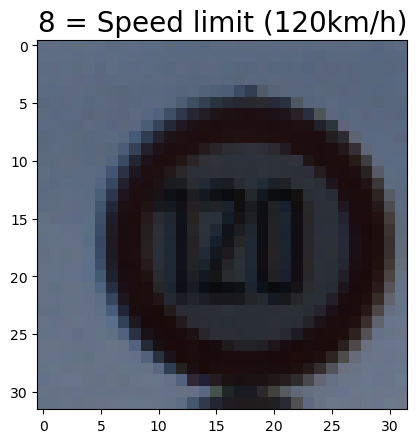

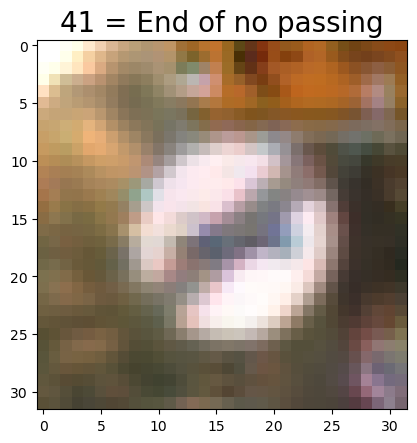

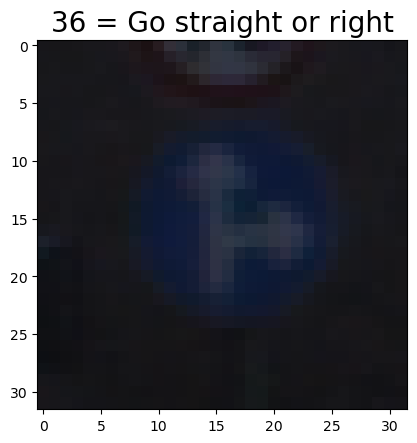

In [15]:
plot_image(train_images, train_labels, signnames, 123)
plot_image(valid_images, valid_labels, signnames, 123)
plot_image(test_images, test_labels, signnames, 123)

We can see that each image is indeed 32x32 pixels, and is in color (RGB).

## Plotting All Classes of Images

Now, let's get an idea of what the images look like for each class.

In [16]:
def plot_all_signs(images, labels, signnames, cmap=None):
    """
    Plots examples of all traffic sign types.

    Args:
        images (numpy.ndarray): Array of traffic sign images.
        labels (numpy.ndarray): Array of corresponding traffic sign labels.
        signnames (dict): Dictionary mapping class IDs to sign names.
        cmap (str or None): Optional. The colormap to be used for image visualization.
                            Defaults to None.

    Returns:
        None: The function displays the plot but does not return any value.
    """
    
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    num_cols = 4
    num_rows = (num_labels - 1) // num_cols + 1

    fig = plt.figure(figsize=(20, 16))

    for i, label in enumerate(unique_labels, 1):
        label_images = images[labels == label]
        plot_image = label_images[0] if len(label_images) > 0 else None
        ax = fig.add_subplot(num_rows, num_cols, i)
        ax.imshow(plot_image, cmap=cmap)
        ax.set_title(f'{label} = {signnames[label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

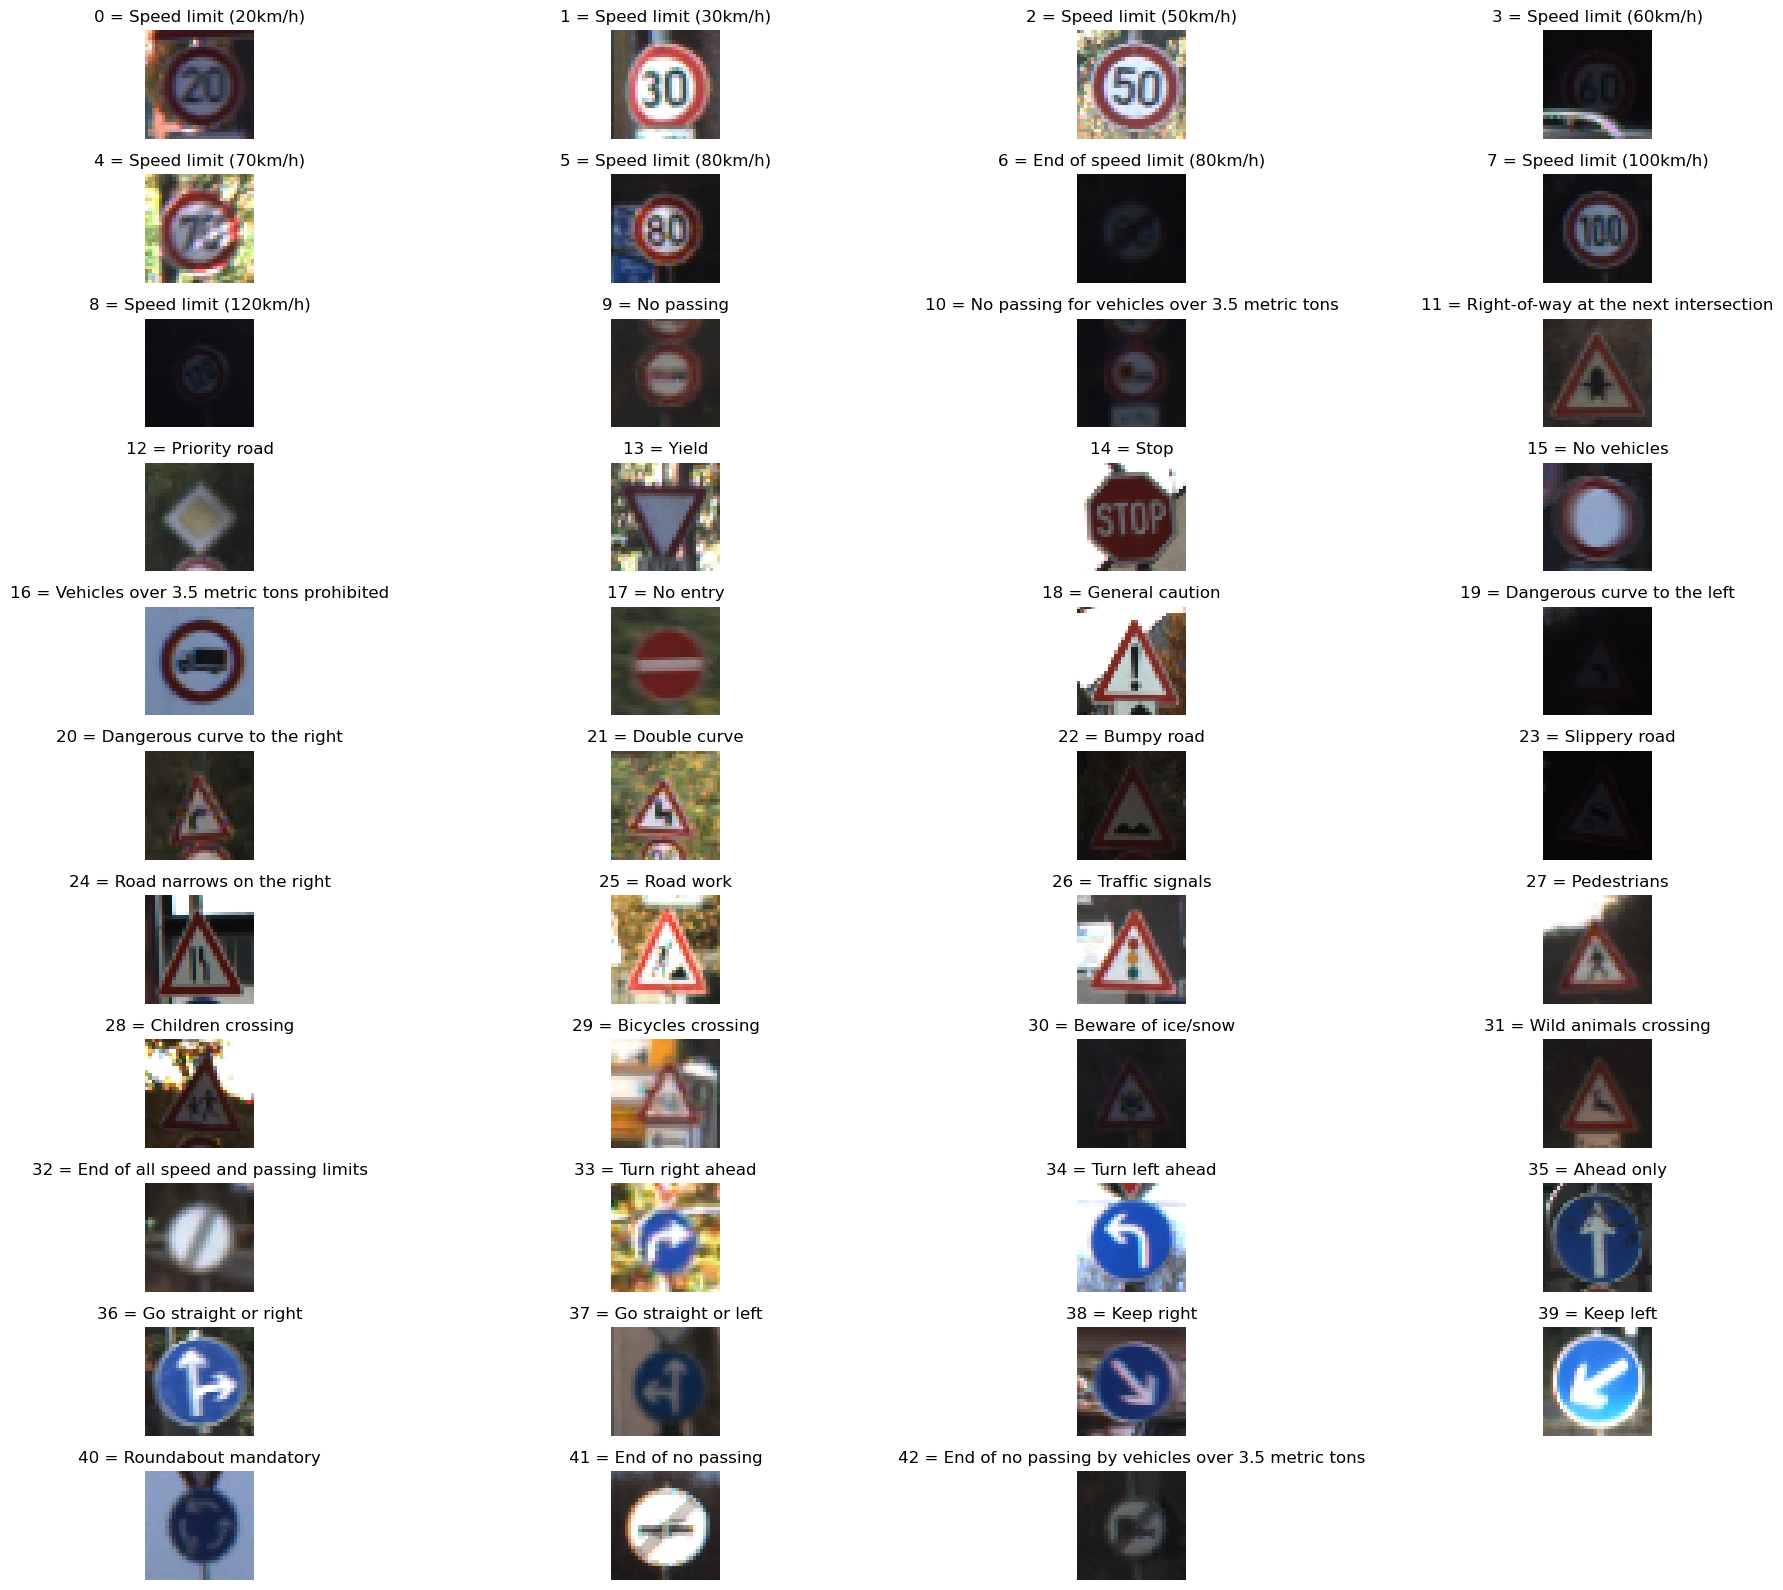

In [17]:
plot_all_signs(train_images, train_labels, signnames)

As you can see in the output image, not all the signs are taking up the same amount of space in the image. Some signs are larger than others, and some are rotated. Not only that but some signs are indiscernible as the image is too dark, or noisy.

Some notable examples:
* `3 - Speed limit (60km/h)`: The sign is dark, and there is an obstruction in the front of it.
* `19 - Dangerous curve to the left`: The sign is almost completely dark, and indiscernible to the human eye.
* `20 - Dangerous curve to the right`: The sign is rotated, and is not taking up the entire image.

These are just a few examples of the types of images we will be working with, as real-life images are not always perfect.

## Plotting Pixel Intensity Distribution by Class

To get a better understanding of these images, let's take a look at the pixel intensity distribution for each class.

In [18]:
def plot_pixel_distribution(images, labels, signnames, selected_labels=None):
    """
    Plots the pixel intensity distribution and box and whisker plot for specified traffic sign class labels.

    Args:
        images (numpy.ndarray): Array of traffic sign images.
        labels (numpy.ndarray): Array of corresponding labels for the traffic sign images.
        signnames (dict): Dictionary mapping class labels to sign names.
        selected_labels (list or None): List of class labels to plot. If None, all unique labels are plotted.
                                        Defaults to None.

    Returns:
        None: The function does not return any value. It displays the plot instead.
    """
    unique_labels = np.unique(labels)

    if selected_labels is None:
        selected_labels = unique_labels

    for label in selected_labels:
        if label not in unique_labels:
            continue

        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Plot pixel distribution
        pixel_values = label_images.flatten()
        axes[0].hist(pixel_values, bins=256, color='gray', alpha=0.7)
        axes[0].set_title(f"Pixel Distribution - {signnames[label]}")
        axes[0].set_xlabel('Pixel Intensity')
        axes[0].set_ylabel('Frequency')

        # Plot box and whisker plot
        axes[1].boxplot(pixel_values)
        axes[1].set_title(f"Box and Whisker Plot - {signnames[label]}")
        axes[1].set_ylabel('Pixel Intensity')

        plt.tight_layout()
        plt.show()


Let's take a look of the pixel intensity distribution for the classes we noted above to see how these images compare to another class.

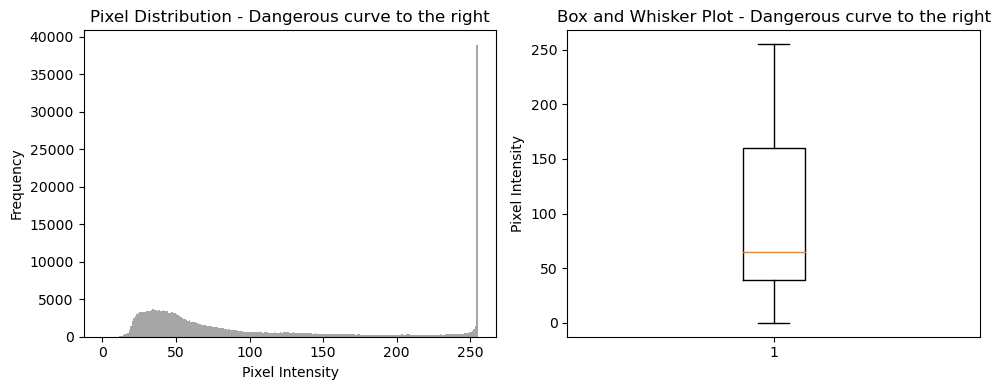

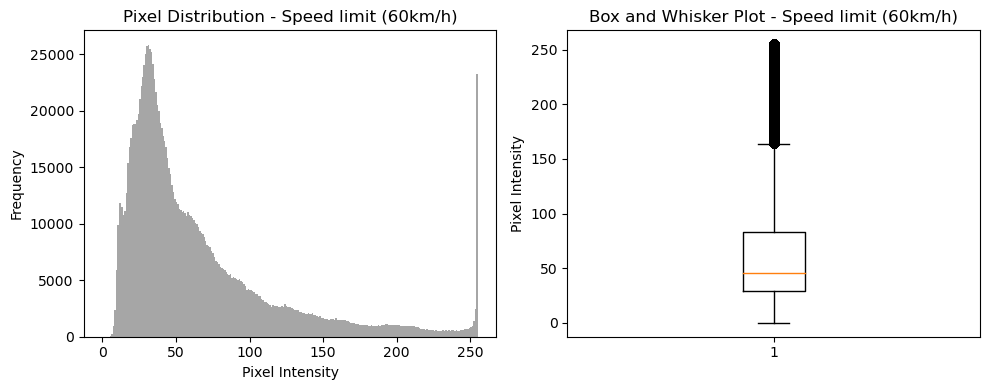

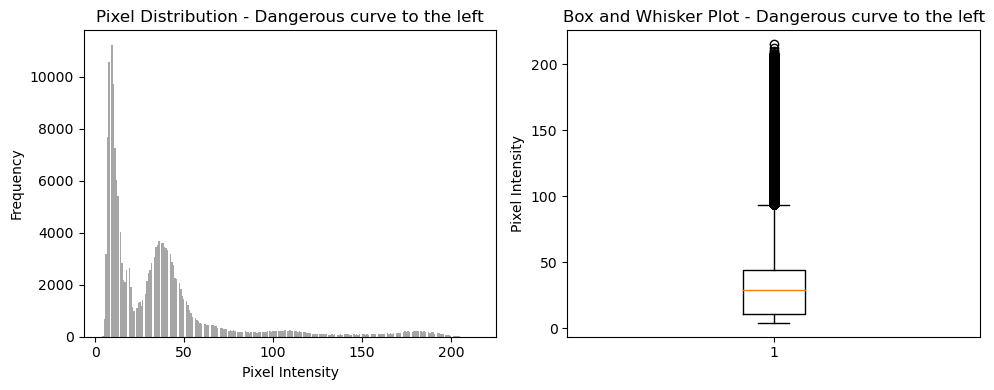

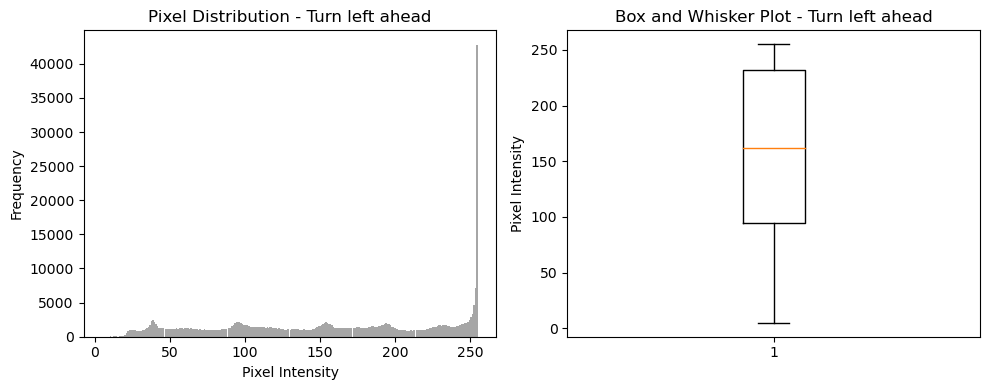

In [19]:
plot_pixel_distribution(train_images, train_labels, signnames, selected_labels=[20, 3, 19, 34])

The pixel intensity distribution reveals distinct characteristics for different traffic sign classes, indicating variations in brightness levels. Wide ranges of pixel intensities suggest better visibility and contrast, while narrow ranges of pixel intensities suggest poor visibility and contrast.

It appears the images belonging to `19 - Dangerous Curve to the Left` have the lowest pixel intensity distribution, indicating poor visibility and contrast. This is consistent with our observation that the sample image is almost completely dark, and indiscernible to the human eye. Class `34 - Turn Left Ahead` has a much better pixel intensity distribution, indicating better visibility and contrast. This is consistent with our observation that the sample image is bright and clear.

Obviously sample images cannot be representative of the entire dataset though, but it does give us a good idea of what we are working with.

## Plotting Number of Images per Class

Now let's take a look at the distribution of the number of images per class.

In [20]:
def plot_label_counts(labels, signnames, title=""):
    """
    Plots the label counts for the specified traffic sign data.

    Args:
        labels (numpy.ndarray): Array of traffic sign labels.
        signnames (dict): Dictionary mapping class labels to sign names.
        title (str): Optional. Title for the plot. Defaults to an empty string.
    
    Returns:
        None: The function does not return any value. It displays the plot instead.
    """

    unique_labels, label_counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(label_counts)[::-1]  # Sort indices in descending order based on count

    sorted_labels = unique_labels[sorted_indices]
    sorted_counts = label_counts[sorted_indices]

    fig = plt.figure(figsize=(15, 5))
    plt.bar(range(len(sorted_labels)), sorted_counts)
    plt.xticks(range(len(sorted_labels)), [signnames[i] for i in sorted_labels], rotation='vertical')
    plt.title(f"Label Counts of {title} Data", fontsize=20)
    plt.show()

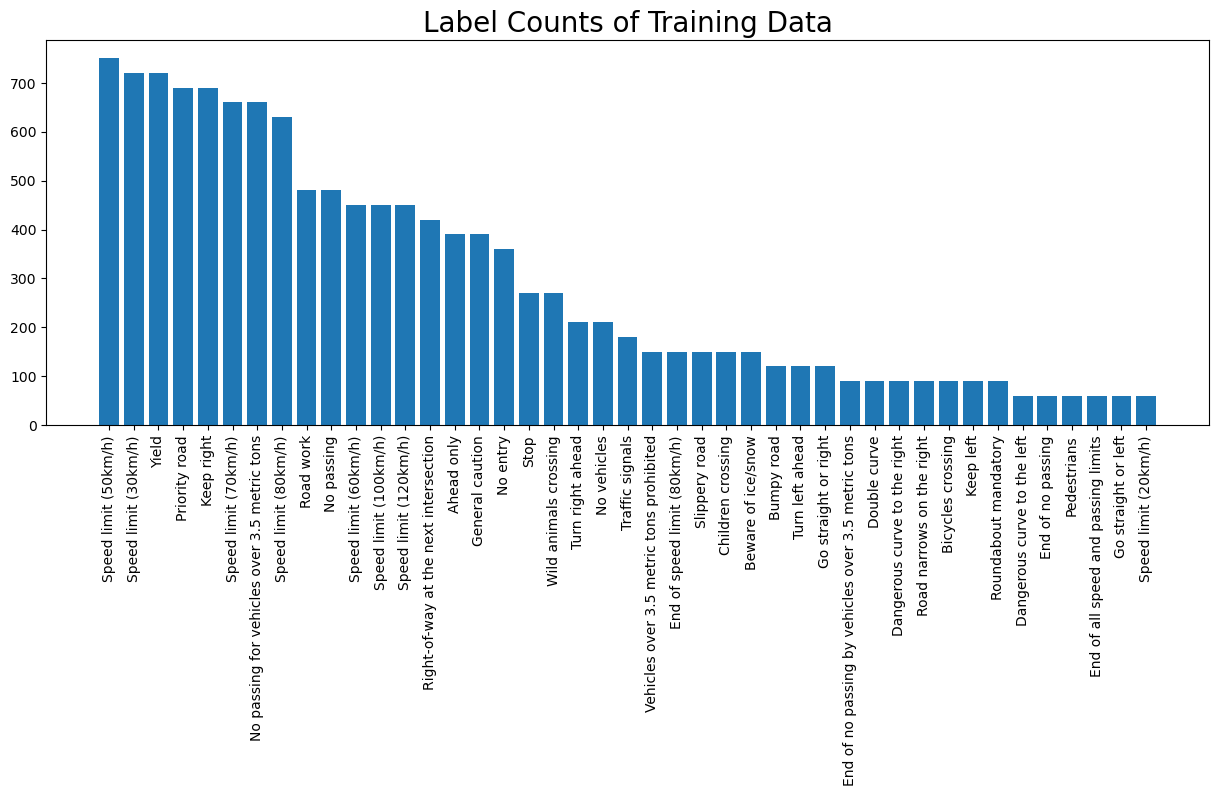

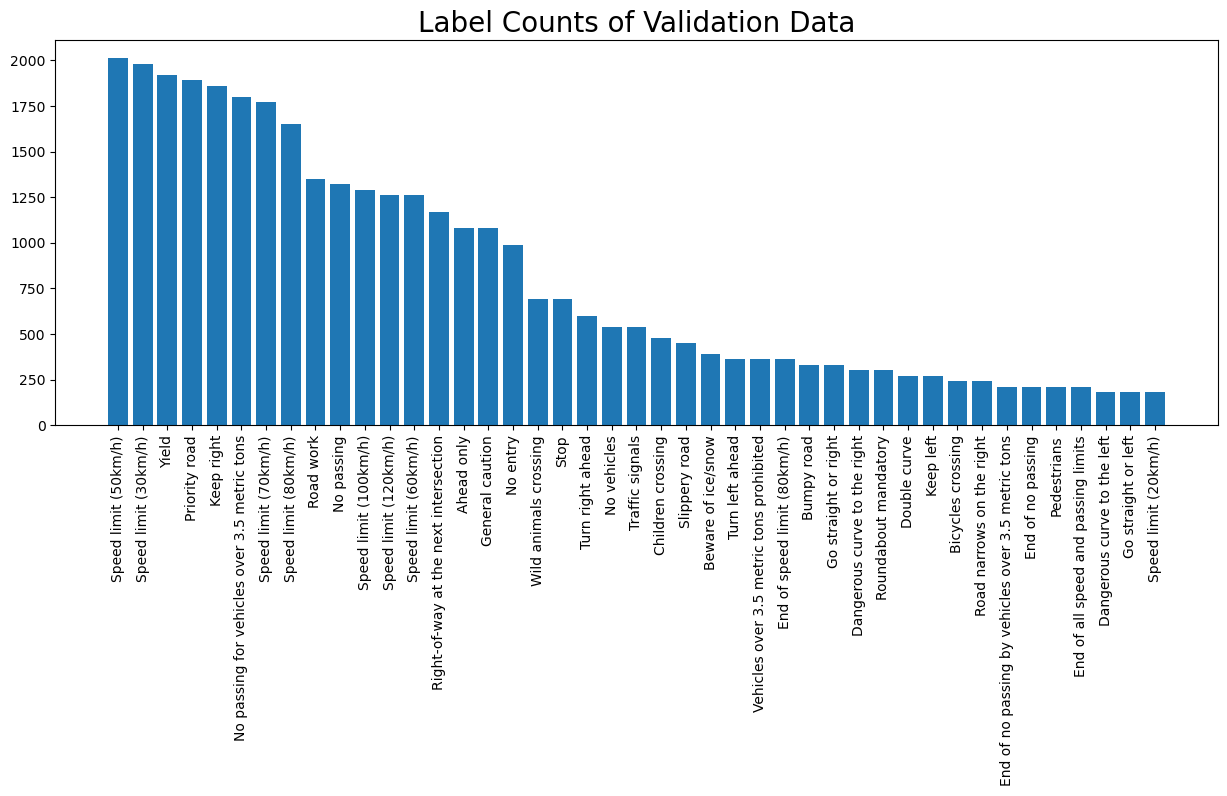

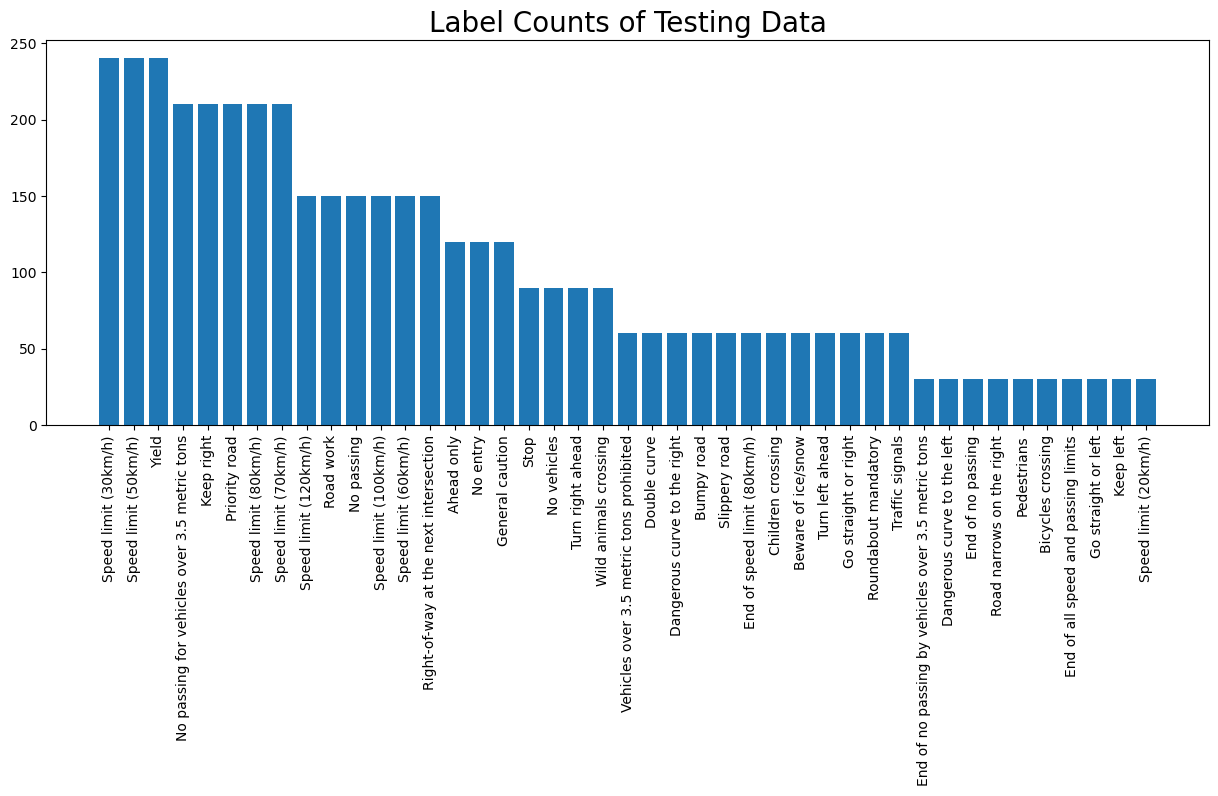

In [21]:
plot_label_counts(train_labels, signnames, "Training")
plot_label_counts(valid_labels, signnames, "Validation")
plot_label_counts(test_labels, signnames, "Testing")

We can see that the number of images per class varies greatly in all three of our datasets. This is important to note, as it will impact our model training and evaluation.

# Data Preprocessing
Now that we have a better understanding of our data, we can begin preprocessing our data for model training.

We understand that our images are not all the same size, and that some images are rotated, dark, or noisy. We also understand that the number of images per class varies greatly in all three of our datasets. We will need to address these issues before we can begin training our model.

## Shuffle Data

First, let's shuffle our training data. Shuffling the data refers to the randomization of the order of the examples in our dataset.

This will ensure that our data is not ordered in any way, and will help prevent any bias and overfitting in our model.

In [22]:
def shuffle_data(images, labels):
    """
    Shuffles the data.

    Args:
        images (numpy.ndarray): An array of images.
        labels (numpy.ndarray): An array of labels.

    Returns:
        numpy.ndarray, numpy.ndarray: The shuffled images and labels.
    """
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    return images[indices], labels[indices]

In [23]:
print("Before shuffling: ", train_labels[:10])

train_images, train_labels = shuffle_data(train_images, train_labels)

print("After shuffling: ", train_labels[:10])

Before shuffling:  [16  1 38 33 11 38 18 12 25 35]
After shuffling:  [ 2 10 11  4 12 13  5 38  3 38]


## Normalize Data

Next, let's normalize our data. Normalizing our data will ensure that our data is scaled to a range of 0 to 1.

Normalizing the data improves the numeric stability of computations during the training. This also ensures that all the features contribute equally to the result.

Not only that, but also this step is required for some models to work properly.

In [24]:
def normalize_images(images):
    """
    Normalize images to [0, 1] scale.

    Args:
        images (numpy.ndarray): An array of images.

    Returns:
        numpy.ndarray: The normalized images.
    """
    # 0,255 -> 0,1
    return np.divide(images, 255.0)

We will create new variables for our normalized data. 

We add a `P` at the end to indicate that the data is preprocessed.

In [25]:
train_images_P = normalize_images(train_images)
valid_images_P = normalize_images(valid_images)
test_images_P = normalize_images(test_images)

## Oversample Data

Next, let's oversample our data. Oversampling our data refers to the process of randomly duplicating examples in our dataset.

This will ensure that the number of images per class is more balanced, and will help prevent any bias and overfitting in our model.

In [26]:
def oversample_images(images, labels, signnames, min_count=300):
    """
    Oversamples images to a minimum count.

    Args:
        images (numpy.ndarray): An array of images.
        labels (numpy.ndarray): An array of labels.
        min_count (int): The minimum number of images per label.

    Returns:
        numpy.ndarray, numpy.ndarray: The oversampled images and labels.
    """
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_count = len(label_images)

        if label_count < min_count:
            num_copies = int(np.ceil((min_count - label_count) / label_count))
            label_images = np.repeat(label_images, num_copies, axis=0)
            label_images = label_images[:min_count - label_count]
            label_labels = np.repeat(label, len(label_images))
            images = np.concatenate((images, label_images), axis=0)
            labels = np.concatenate((labels, label_labels), axis=0)

    return shuffle_data(images, labels) # Shuffle the data again after oversampling

In [27]:
train_images_P, train_labels = oversample_images(train_images_P, train_labels, signnames)

Now let's look at the distribution of the number of images per class for our oversampled data.

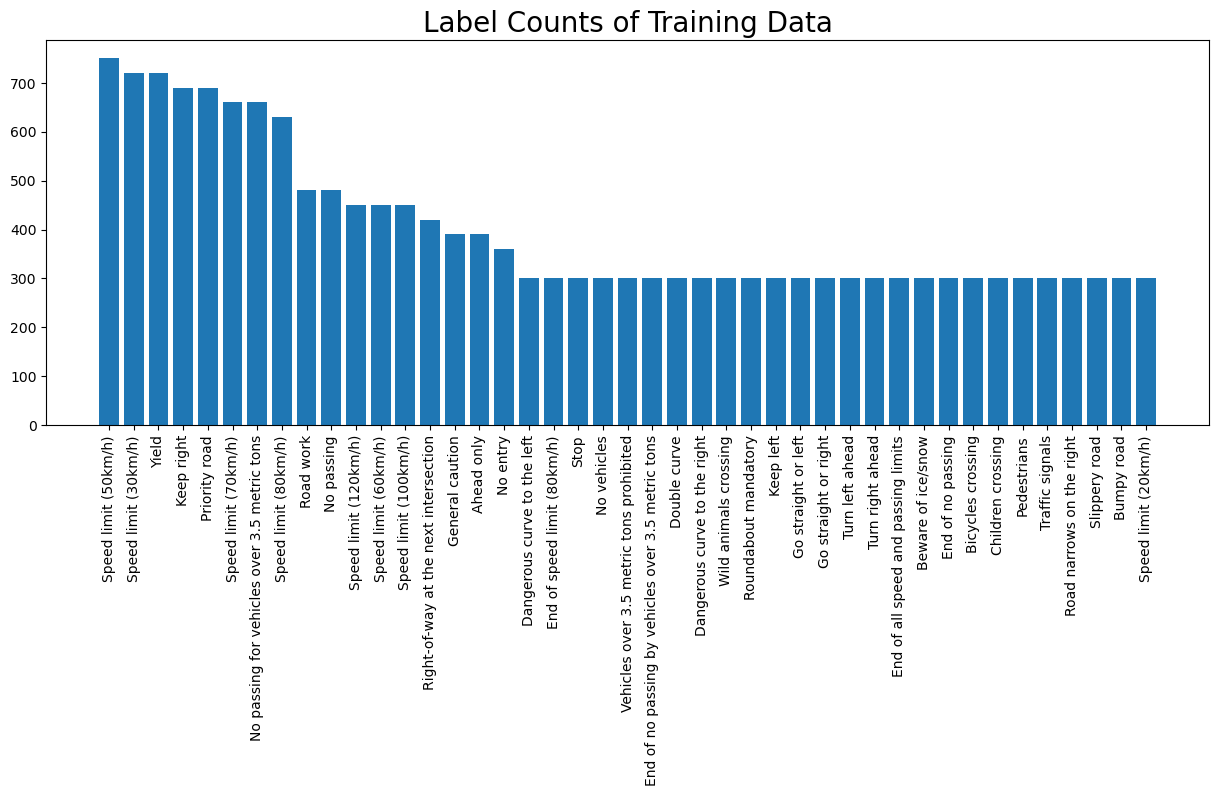

In [28]:
plot_label_counts(train_labels, signnames, "Training")

In [29]:
print("Before oversampling: ", train_images.shape, train_labels.shape)
print("After oversampling: ", train_images_P.shape, train_labels.shape)

Before oversampling:  (12630, 32, 32, 3) (17190,)
After oversampling:  (17190, 32, 32, 3) (17190,)


Our oversampled data is much more balanced than our original data. This will help prevent any bias and overfitting in our model.

## One-Hot Encode Labels and Convert to Tensors

Next, let's one-hot encode our labels. One-hot encoding our labels refers to the process of converting our labels from a single numeric column to multiple binary columns.

This will ensure that our labels are represented in a way that the model can understand.

In [30]:
train_labels_P = tf.one_hot(train_labels, 43)
valid_labels_P = tf.one_hot(valid_labels, 43)
test_labels_P = tf.one_hot(test_labels, 43)

2023-07-08 14:06:37.951681: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 14:06:38.209714: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 14:06:38.210705: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 14:06:38.212723: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-08 14:06:38.214344: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not op

Converting our images to tensors will also help improve the speed and memory usage of our model.

We will rename our variables with a `Pt` at the end to indicate that the data is preprocessed and tensor transformed.

In [31]:
train_images_Pt = tf.convert_to_tensor(train_images_P, dtype=tf.float32)
valid_images_Pt = tf.convert_to_tensor(valid_images_P, dtype=tf.float32)
test_images_Pt = tf.convert_to_tensor(test_images_P, dtype=tf.float32)

In [32]:
print("Shape of training images: ", train_images_P.shape)
print("Shape of validation images: ", valid_images_P.shape)
print("Shape of testing images: ", test_images_P.shape)
print()
print("Shape of training labels: ", train_labels_P.shape)
print("Shape of validation labels: ", valid_labels_P.shape)
print("Shape of testing labels: ", test_labels_P.shape)

Shape of training images:  (17190, 32, 32, 3)
Shape of validation images:  (34799, 32, 32, 3)
Shape of testing images:  (4410, 32, 32, 3)

Shape of training labels:  (17190, 43)
Shape of validation labels:  (34799, 43)
Shape of testing labels:  (4410, 43)


# Model Training

Now that we have preprocessed our data, we can begin training our model with a Convolutional Neural Network (CNN).


>An Convolutional Neural Network (CNN) is a type of neural network that is used for image classification and recognition. CNNs apply a series of filters to the pixel data of an image to extract and learn higher-level features, which the model can then use for classification. Filters are also known as kernels, which is a smaller-sized matrix used for convolution. Each convolutional layer applies a specific number of filters to the previous layer, and combines their results into a feature map. Pooling layers then reduce the dimensionality of each feature map, further reducing the number of parameters in the model. These pooling layers keep the most important parts of the images. Finally, a fully connected layer is used at the end of the network to perform the classification.
Overall, the purpose of CNN is to detect high-level features with the lowest possible spatial resolution. [[1](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)]

Some potential hyperparameters that should be considered when training a CNN include:
* Number of convolutional layers
* Max Pooling vs. Average Pooling
* Number of filters
* Stride
* Padding
* ... and more


To visualize how are model is trained, we will be plotting the training and validation accuracy and loss for each epoch.

In [33]:
def plot_accuracy_loss(model_history, model_name=""):
    """
    Plots the accuracy and loss of a model.

    Args:
        model_history (tensorflow.python.keras.callbacks.History): The history of the model.
        model_name (str): The name of the model.
    Returns:
        None: Plots the accuracy and loss of a model.
    """

    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Accuracy plot
    ax1.plot(model_history.history['categorical_accuracy'], color='tab:blue')
    ax1.plot(model_history.history['val_categorical_accuracy'], color='tab:orange')
    ax1.set_ylabel('Accuracy', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=16)
    ax1.set_ylim([0, 1.1])

    # Loss plot
    ax2 = ax1.twinx()
    ax2.plot(model_history.history['loss'], color='tab:green')
    ax2.plot(model_history.history['val_loss'], color='tab:red')
    ax2.set_ylabel('Loss', fontsize=16)

    # Legend, title
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, ['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='lower left')
    plt.title('Accuracy and Loss for ' + model_name, fontsize=20)
    plt.show()


I will first implement my own CNN architecture and then compare it to the LeNet architecture.

## Basic CNN Architecture
![](https://d33wubrfki0l68.cloudfront.net/a7664cf19de33b2c71a482629f27a0d70f715b77/6949d/images/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way.jpg)

For the first model, I will be creating a basic CNN with two convolutional layers, two max pooling layers, and two fully connected layers.
I chose a filter size of 32 for my two convolutional layers as it is common practice to start at a smaller number of filters. I chose the kernel size for similiar reasons.
I chose MaxPooling over AveragePooling as it is more commonly used in CNNs and it is know to provde beter translation invariance. This is important as we know that our images are not all the same size, and that some images are rotated and displaced. [[2](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/)]

In [34]:
# Define the model architecture
cnn_baseline = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation 
    layers.MaxPooling2D((2, 2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(64, activation='relu'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# print model summary
cnn_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                73792     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

Epoch 1/20
269/269 [==============================] - 22s 52ms/step - loss: 2.8985 - categorical_accuracy: 0.2506 - val_loss: 1.8054 - val_categorical_accuracy: 0.5050
Epoch 2/20
269/269 [==============================] - 5s 18ms/step - loss: 0.7532 - categorical_accuracy: 0.7938 - val_loss: 1.3485 - val_categorical_accuracy: 0.6867
Epoch 3/20
269/269 [==============================] - 5s 18ms/step - loss: 0.3032 - categorical_accuracy: 0.9236 - val_loss: 1.2824 - val_categorical_accuracy: 0.7242
Epoch 4/20
269/269 [==============================] - 5s 17ms/step - loss: 0.1723 - categorical_accuracy: 0.9554 - val_loss: 1.3147 - val_categorical_accuracy: 0.7563
Epoch 5/20
269/269 [==============================] - 5s 17ms/step - loss: 0.1293 - categorical_accuracy: 0.9644 - val_loss: 1.2060 - val_categorical_accuracy: 0.7767
Epoch 6/20
269/269 [==============================] - 5s 20ms/step - loss: 0.0715 - categorical_accuracy: 0.9839 - val_loss: 1.3471 - val_categorical_accuracy: 0.78

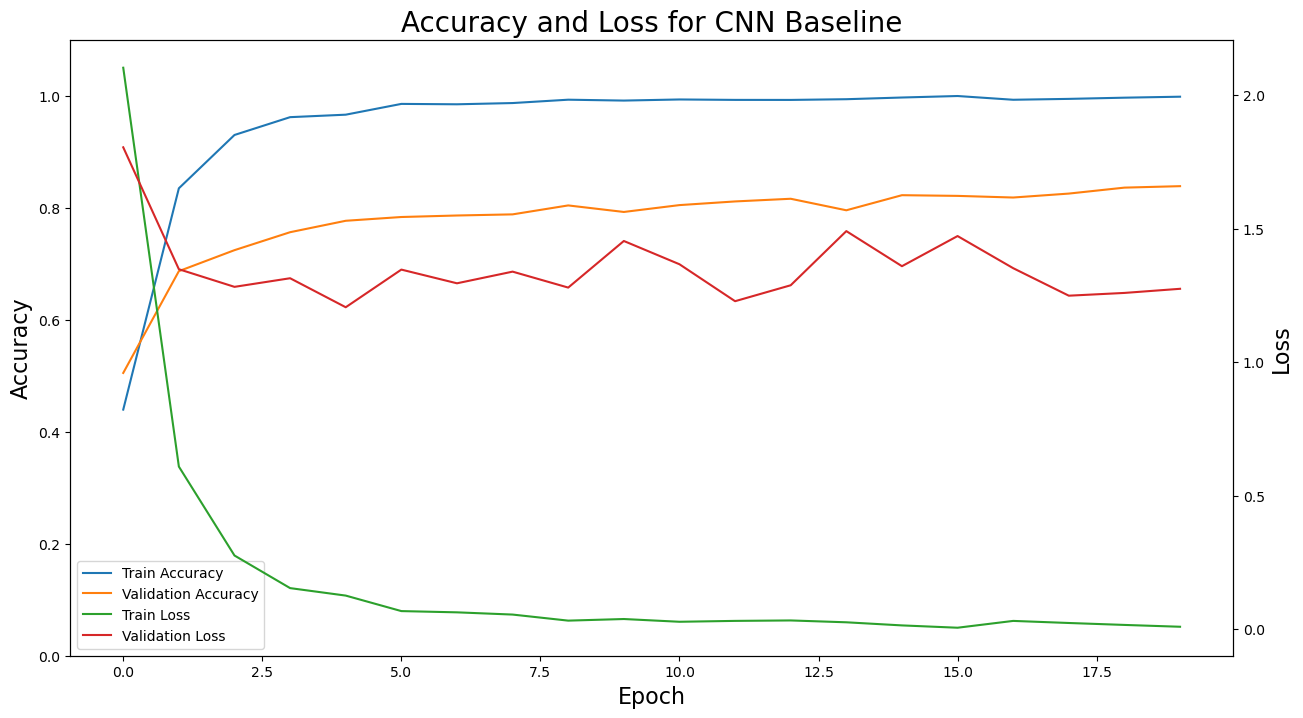

In [35]:
start_time = timeit.default_timer()

cnn_baseline_history = cnn_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=20, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {(end_time - start_time)/60} minutes")

plot_accuracy_loss(cnn_baseline_history, "CNN Baseline")

It appears that the model is overfitting to the training data.  The loss of the validation data does not decrease by much and appears very noisy. The accuracy of the validation data is ~15% lower than the accuracy of the training data.

I will try to see how the model performs with regularization and dropout layers to the model to see if that helps.

>Regularization is a technique used to reduce overfitting in neural networks. It does this by adding a penalty to the loss function. This penalty is an additional term that is added to the loss function. The penalty term is a function of the weights of the neural network. The regularization term is only added to the loss function during training. During testing, the regularization term is not added to the loss function. [[3](https://www.analyticsvidhya.com/blog/2021/06/complete-guide-to-prevent-overfitting-in-neural-networks-part-1/)]

>Dropout is a technique used to reduce overfitting in neural networks. It does this by randomly dropping neurons during training. This forces the neural network to learn with different neurons during each epoch. This prevents the neural network from relying on any one neuron to learn the features of the data. During testing, all neurons are used. [[4](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)]

## Basic CNN Model with Dropout Layers and Ridge Regularization

I will be using the same model as before, but this time, I'm adding dropout layers and ridge regularization to the model.

I am using a L2 regularization penalty as it reduces the weights of the neural network by a factor of the learning rate. It's important to reduce these weights as images with noise and rotation can cause the model to overfit to the training data, and this type of regularization has a robustness to outliers.

I am adding dropout layers between the dense layers so my model can learn with different neurons during each epoch. I started with a value of `0.5` for this, however I found a value of `0.4` to work better.

In [36]:
# Define the model architecture
cnn_regularized_dropout = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer

    layers.Flatten(), # flatten layer

    layers.Dense(64, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.40), # dropout layer - probability chance of dropping a neuron
    layers.Dense(64, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.40), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

cnn_regularized_dropout.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                73792     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Epoch 1/20
269/269 [==============================] - 8s 26ms/step - loss: 3.6554 - categorical_accuracy: 0.0739 - val_loss: 2.4091 - val_categorical_accuracy: 0.3552
Epoch 2/20
269/269 [==============================] - 6s 21ms/step - loss: 2.3410 - categorical_accuracy: 0.3071 - val_loss: 1.5381 - val_categorical_accuracy: 0.6048
Epoch 3/20
269/269 [==============================] - 7s 25ms/step - loss: 1.6083 - categorical_accuracy: 0.5148 - val_loss: 1.1825 - val_categorical_accuracy: 0.6783
Epoch 4/20
269/269 [==============================] - 6s 22ms/step - loss: 1.2767 - categorical_accuracy: 0.6244 - val_loss: 0.9615 - val_categorical_accuracy: 0.7454
Epoch 5/20
269/269 [==============================] - 6s 21ms/step - loss: 1.0923 - categorical_accuracy: 0.6863 - val_loss: 0.8644 - val_categorical_accuracy: 0.7894
Epoch 6/20
269/269 [==============================] - 6s 22ms/step - loss: 0.9492 - categorical_accuracy: 0.7367 - val_loss: 0.7858 - val_categorical_accuracy: 0.815

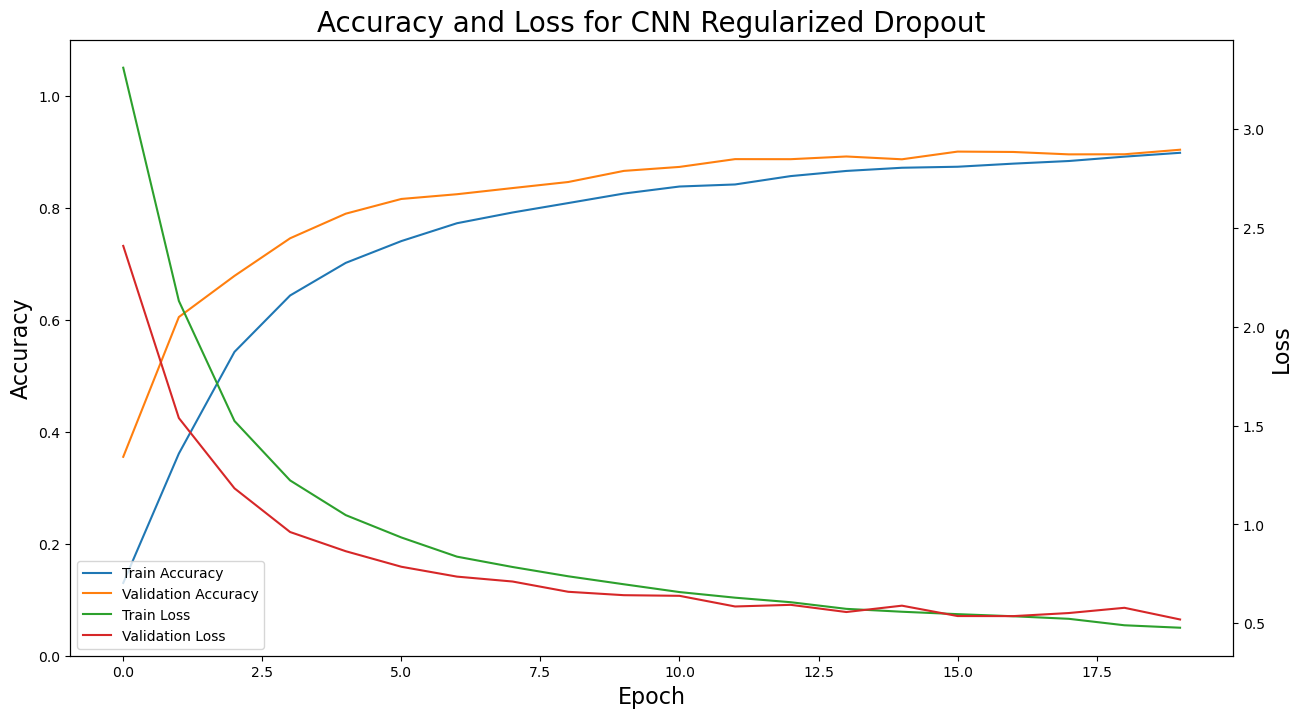

In [37]:
start_time = timeit.default_timer()

cnn_regularized_dropout_history = cnn_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=20, batch_size=64)

end_time = timeit.default_timer()

print(f"Execution time: {(end_time - start_time)/60} minutes")

plot_accuracy_loss(cnn_regularized_dropout_history, "CNN Regularized Dropout")

After adding the L2 regularization and dropout layers, the model significantly improves! The loss of the validation data decreases by a lot and is much less noisy. The accuracy of the validation data is now greater on earlier epochs (which is expected from the regularization and dropout layers), and lines up with the accuracy of the training data.

## Basic LeNet5 Model

![](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)


>LeNet5 is one of the applications of the Convolution Neural Network. Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner developed it in 1989. CNN is a feed-forward neural network whose neurons can respond to the neighboring neurons and was developed for the recognition of handwritten and machine-printed characters. [[5](https://towardsai.net/p/deep-learning/the-architecture-and-implementation-of-lenet-5)]

This model differs from our basic CNN architecture as it uses AveragePooling instead of MaxPooling, and uses tanh activation instead of relu activation.
It also uses a different number of filters and kernel sizes in each convolutional layer, and has one additional convolutional layers of 120 kernels before the data is flatten and feed to our dense layers.


In [38]:
# Define the model architecture
lenet_baseline = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='same', activation='tanh', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.AveragePooling2D(), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='tanh', padding='valid'), # convulation layer + relu activation 
    layers.AveragePooling2D(),# average pooling layer
    layers.Conv2D(filters=120, kernel_size=(5, 5), strides=(1,1), activation='tanh', padding='valid'), # convulation layer + relu activation

    layers.Flatten(), # flatten layer
    
    layers.Dense(84, activation='tanh'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_baseline.summary()) # see model architecture

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

Epoch 1/20
269/269 [==============================] - 21s 56ms/step - loss: 2.4853 - categorical_accuracy: 0.3771 - val_loss: 0.9493 - val_categorical_accuracy: 0.7328
Epoch 2/20
269/269 [==============================] - 6s 22ms/step - loss: 0.3828 - categorical_accuracy: 0.9259 - val_loss: 0.6768 - val_categorical_accuracy: 0.8084
Epoch 3/20
269/269 [==============================] - 6s 21ms/step - loss: 0.1597 - categorical_accuracy: 0.9739 - val_loss: 0.6383 - val_categorical_accuracy: 0.8196
Epoch 4/20
269/269 [==============================] - 6s 21ms/step - loss: 0.0967 - categorical_accuracy: 0.9850 - val_loss: 0.6205 - val_categorical_accuracy: 0.8272
Epoch 5/20
269/269 [==============================] - 6s 21ms/step - loss: 0.0628 - categorical_accuracy: 0.9918 - val_loss: 0.5803 - val_categorical_accuracy: 0.8392
Epoch 6/20
269/269 [==============================] - 6s 22ms/step - loss: 0.0412 - categorical_accuracy: 0.9944 - val_loss: 0.6011 - val_categorical_accuracy: 0.83

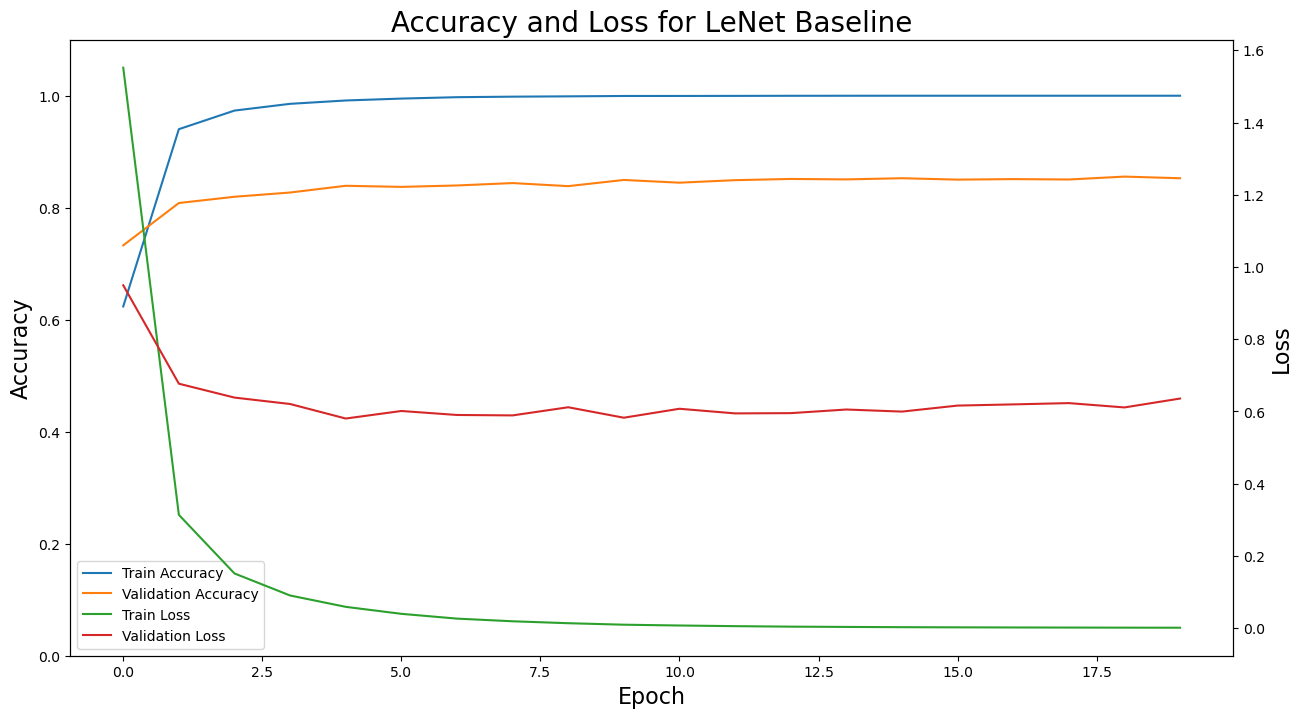

In [39]:
start_time = timeit.default_timer()

lenet_baseline_history = lenet_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=20, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {(end_time - start_time)/60} minutes")

plot_accuracy_loss(lenet_baseline_history, "LeNet Baseline")

Once again, we have a model that is overfitting to the training data, and the loss function of the validation data is somewhat noisy. The accuracy of the validation data is ~15% lower than the accuracy of the training data.

Let's add ridge regularization and dropout layers to the LeNet5 model to see if that helps.

## LeNet5 Model with Dropout Layers and Ridge Regularization

We will once again add dropout layers in between the dense layers and ridge regularization to the model.

In [40]:
# Define the model architecture
lenet_regularized_dropout = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='same', activation='tanh', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.AveragePooling2D(), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='tanh', padding='valid'), # convulation layer + relu activation 
    layers.AveragePooling2D(),# average pooling layer
    layers.Conv2D(filters=120, kernel_size=(5, 5), strides=(1,1), activation='tanh', padding='valid'), # convulation layer + relu activation
    layers.Dropout(0.40), # dropout layer - probability chance of dropping a neuron

    layers.Flatten(), # flatten layer
    
    layers.Dense(84, activation='tanh', kernel_regularizer = L2(0.001)), # fully connected layer + relu activation
    layers.Dropout(0.40), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_regularized_dropout.summary()) # see model architecture

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 120)         48120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 120)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)              

Epoch 1/20
269/269 [==============================] - 7s 24ms/step - loss: 2.8873 - categorical_accuracy: 0.3003 - val_loss: 1.1900 - val_categorical_accuracy: 0.7066
Epoch 2/20
269/269 [==============================] - 6s 23ms/step - loss: 0.9015 - categorical_accuracy: 0.7984 - val_loss: 0.8389 - val_categorical_accuracy: 0.8051
Epoch 3/20
269/269 [==============================] - 6s 22ms/step - loss: 0.5643 - categorical_accuracy: 0.8890 - val_loss: 0.7284 - val_categorical_accuracy: 0.8274
Epoch 4/20
269/269 [==============================] - 6s 22ms/step - loss: 0.4426 - categorical_accuracy: 0.9212 - val_loss: 0.6468 - val_categorical_accuracy: 0.8476
Epoch 5/20
269/269 [==============================] - 6s 22ms/step - loss: 0.3543 - categorical_accuracy: 0.9361 - val_loss: 0.6122 - val_categorical_accuracy: 0.8526
Epoch 6/20
269/269 [==============================] - 6s 23ms/step - loss: 0.2900 - categorical_accuracy: 0.9535 - val_loss: 0.5862 - val_categorical_accuracy: 0.856

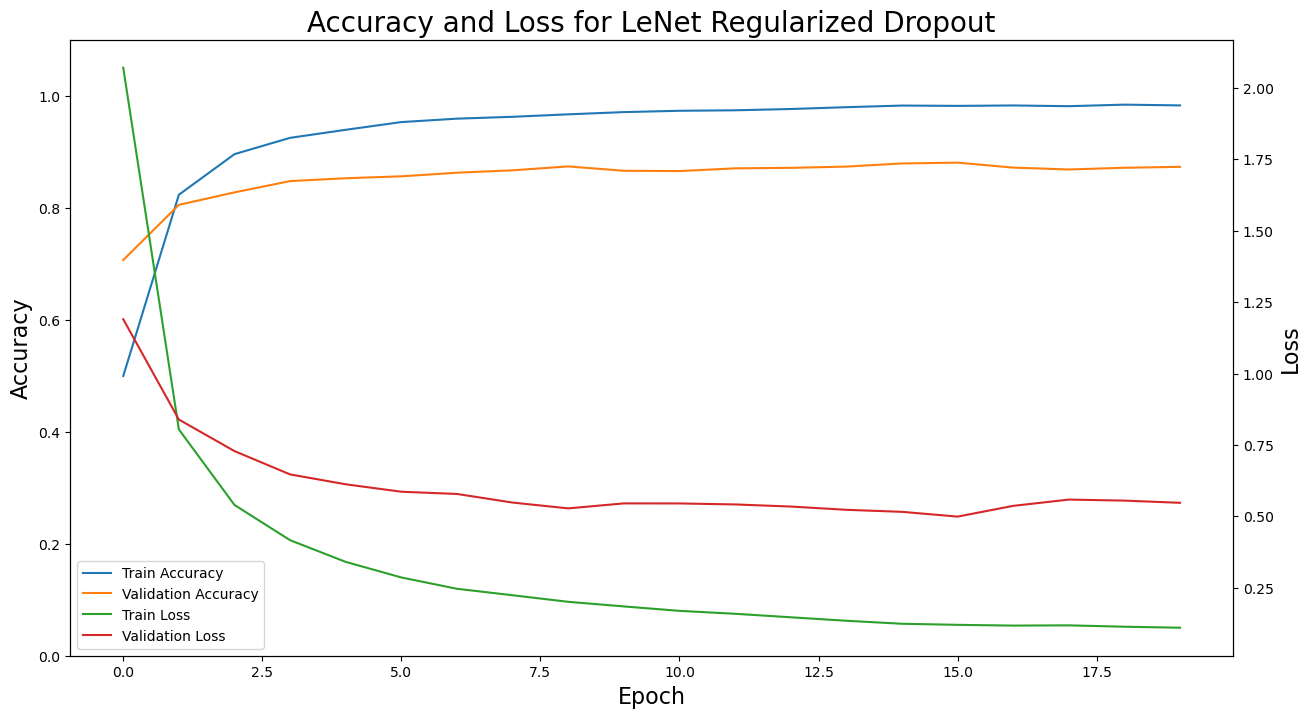

In [41]:
# fit / train the model
start_time = timeit.default_timer()

lenet_regularized_dropout_history = lenet_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=20, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {(end_time - start_time)/60} minutes")

plot_accuracy_loss(lenet_regularized_dropout_history, "LeNet Regularized Dropout")

This model is much better than the previous LeNet5 model. The loss of the validation data decreases by a lot and is much less noisy. We see that the model is still overfit however, and the accuracy of the validation data is still ~10% lower than the accuracy of the training data.

## Saving the Best Models

We can save our two strong models `cnn_regularized_dropout` and `lenet5_regularized_dropout` to use for our final model evaluation.

In [42]:
# save all the models
#cnn_regularized_dropout.save('cnn_regularized_dropout')
#lenet_regularized_dropout.save('lenet_regularized_dropout')

# Model Evaluation

Now that we have trained our models, we can evaluate our model on the test set.

## Evaluate Model on Test Set

In [43]:
test_loss_cnn, test_accuracy_cnn = cnn_regularized_dropout.evaluate(test_images_Pt, test_labels_P)
print("Test Loss for Best CNN Model:", test_loss_cnn)
print("Test Accuracy for Best CNN Model:", test_accuracy_cnn)

test_loss_lenet, test_accuracy_lenet = lenet_regularized_dropout.evaluate(test_images_Pt, test_labels_P)
print("Test Loss for Best LeNet5 Model:", test_loss_lenet)
print("Test Accuracy for Best LeNet5 Model:", test_accuracy_lenet)

138/138 [==============================] - 4s 18ms/step - loss: 0.5113 - categorical_accuracy: 0.9084
Test Loss for Best CNN Model: 0.5113134980201721
Test Accuracy for Best CNN Model: 0.9083900451660156
138/138 [==============================] - 5s 22ms/step - loss: 0.5441 - categorical_accuracy: 0.8755
Test Loss for Best LeNet5 Model: 0.5440585017204285
Test Accuracy for Best LeNet5 Model: 0.8755102157592773


Both models have decent accuracy on the test set, but the `cnn_regularized_dropout` model has a slightly higher accuracy than the `lenet5_regularized_dropout` model.
This makes sense as the LeNet5 model was seen to be still overfit to the training data.

## Confusion Matrix

Let's take a look at the confusion matrix for our model. We can see what classes our model is getting confused with.

In [44]:
def plot_confusion_matrix(model, test_images, test_labels, signnames, model_name=""):
    """
    Plots the confusion matrix for a given model.

    Args:
        model: trained model
        test_images: images from the test set
        test_labels: labels from the test set
        signnames: list of signnames
    
    Returns:
        None: plots the confusion matrix
    """

    # Make predictions on the test data
    test_predictions = model.predict(test_images)
    
    # Convert predictions from one-hot encoding to class labels
    test_predicted_labels = np.argmax(test_predictions, axis=1)
    
    # Convert true labels from one-hot encoding to class labels
    test_true_labels = np.argmax(test_labels, axis=1)
    
    # Create a confusion matrix
    confusion_matrix = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cbar=False, cmap=plt.cm.RdBu)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(np.arange(len(signnames)), [signnames[i] for i in range(len(signnames))], rotation='vertical')
    plt.yticks(np.arange(len(signnames)), [signnames[i] for i in range(len(signnames))], rotation='horizontal')
    plt.show()

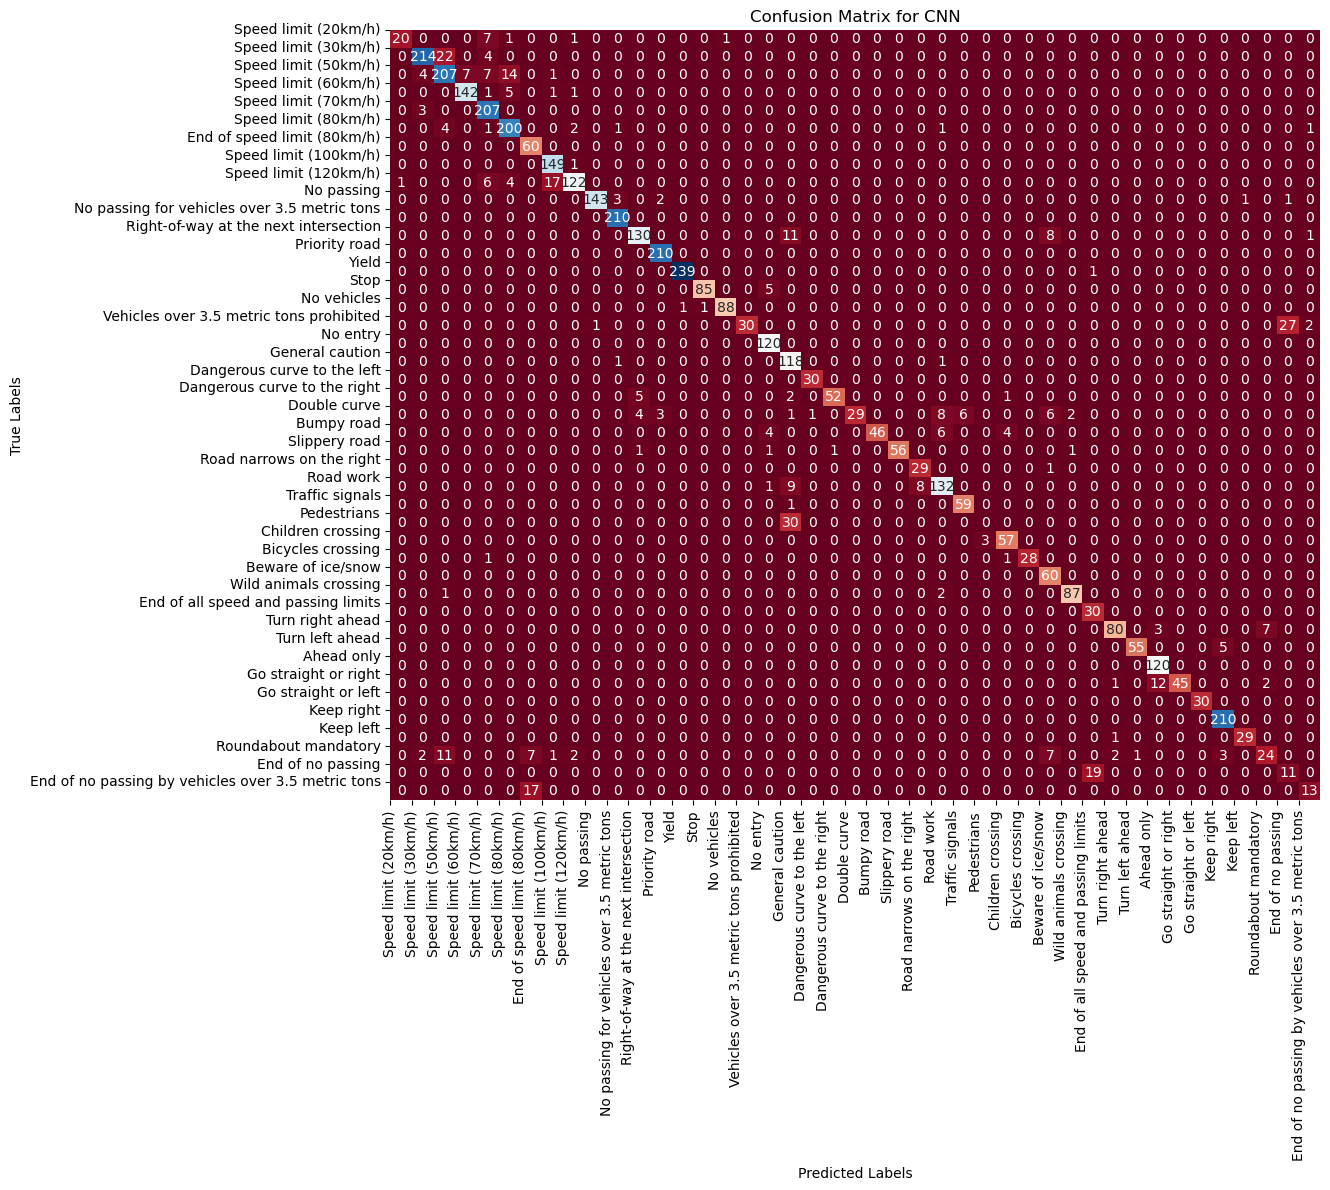

In [45]:
plot_confusion_matrix(cnn_regularized_dropout, test_images_Pt, test_labels_P, signnames, "CNN")

The sign classes that our CNN model is getting confused with the most are:
* `Speed Limit (20km/h)`
* `End of no passing`
* `Roundabout Manadatory`
* `Go straight or right`

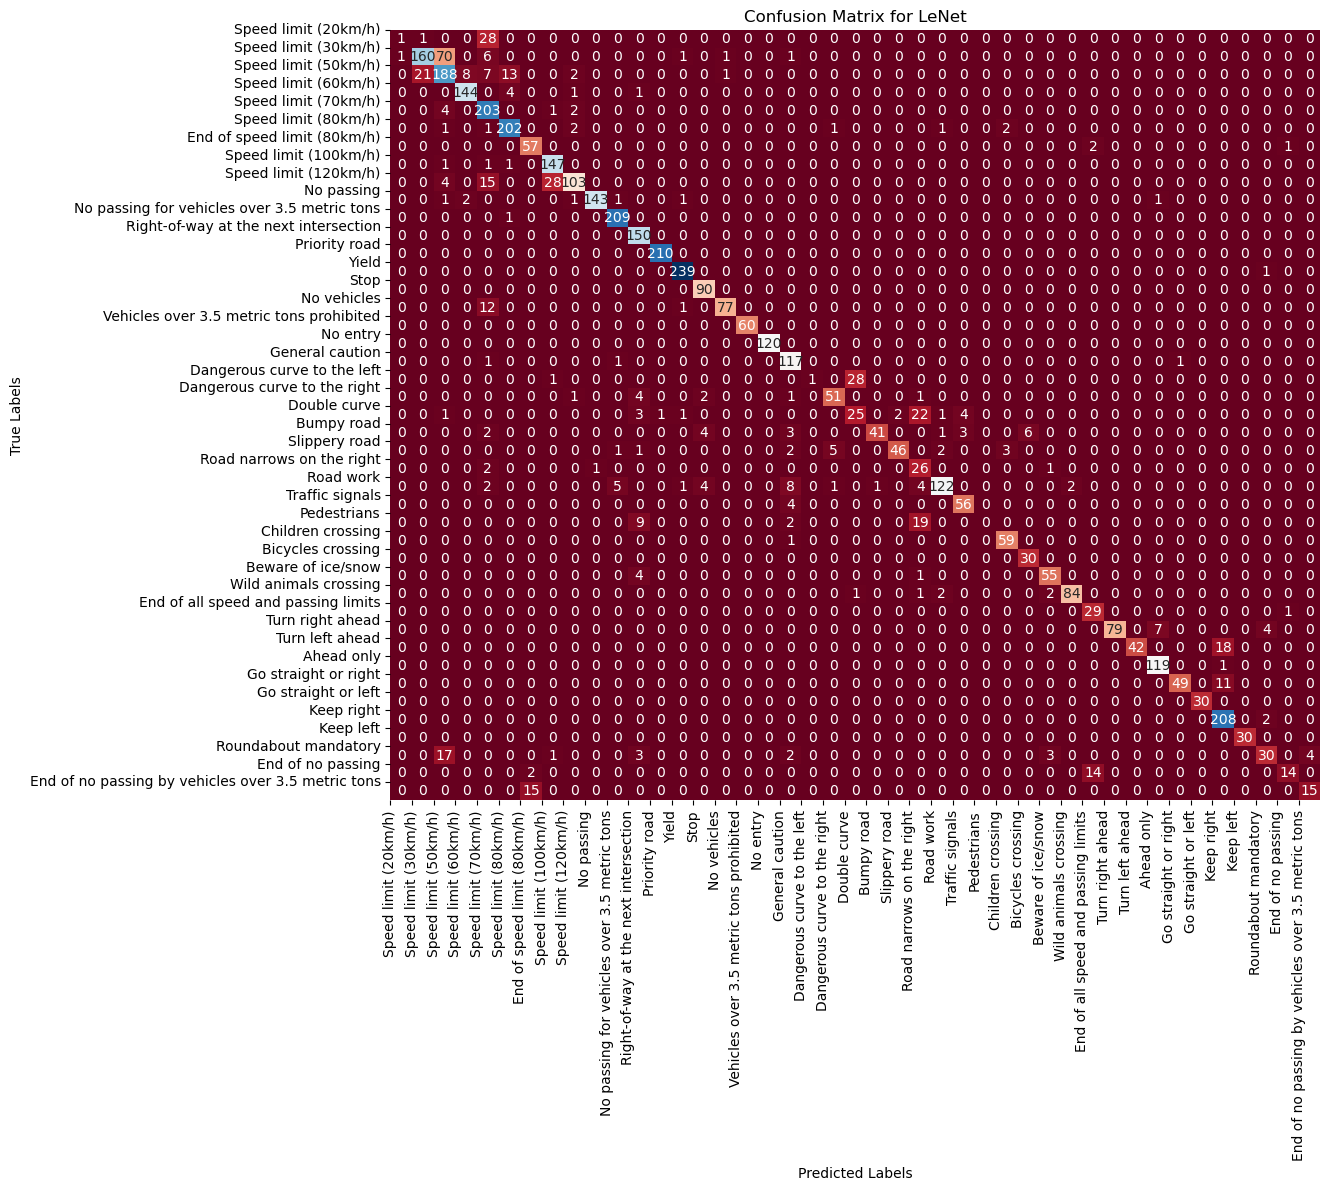

In [46]:
plot_confusion_matrix(lenet_regularized_dropout, test_images_Pt, test_labels_P, signnames, "LeNet")

The sign classes that our LeNet5 model is getting confused with the most are:
* `Speed Limit (120km/h)`
* `Pedestrians`
* `Road work`
* `Double curve`

## Plot Misclassified Images

Let's plot some of the misclassified images to see what our models are getting wrong.

In [47]:
def plot_misclassified_images(images, true_labels, predicted_labels, signnames):
    """
    Plots the misclassified traffic sign images.

    Args:
        images (np.ndarray): Array of traffic sign images.
        true_labels (np.ndarray): Array of true labels.
        predicted_labels (np.ndarray): Array of predicted labels.
        signnames (dict): Dictionary containing sign names.

    Returns:
        None: plots the misclassified images
    """
    misclassified_indices = np.where(true_labels != predicted_labels)[0]
    # take 5 random misclassified indices
    random_misclassified_indices = np.random.choice(misclassified_indices, 5, replace=False)

    for index in random_misclassified_indices:
        print(f"Index of misclassied image: {index}")
        true_label = true_labels[index]
        predicted_label = predicted_labels[index]
        image = images[index]
        # plot the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        # plot image of the incorrect label
        plt.title(f"Image {index} -- True label: {signnames[true_label]} | Predicted: {signnames[predicted_label]}")

First we need to grab the predictions for the test set for each model.

In [48]:
predictions_cnn = cnn_regularized_dropout.predict(test_images_Pt)
predictions_cnn = np.argmax(predictions_cnn, axis=1)

predictions_lenet = lenet_regularized_dropout.predict(test_images_Pt)
predictions_lenet = np.argmax(predictions_lenet, axis=1)

And plot some of the misclassified images for each model.

### Misclassified Images for `cnn_regularized_dropout`

Index of misclassied image: 706
Index of misclassied image: 334
Index of misclassied image: 4261
Index of misclassied image: 1160
Index of misclassied image: 573


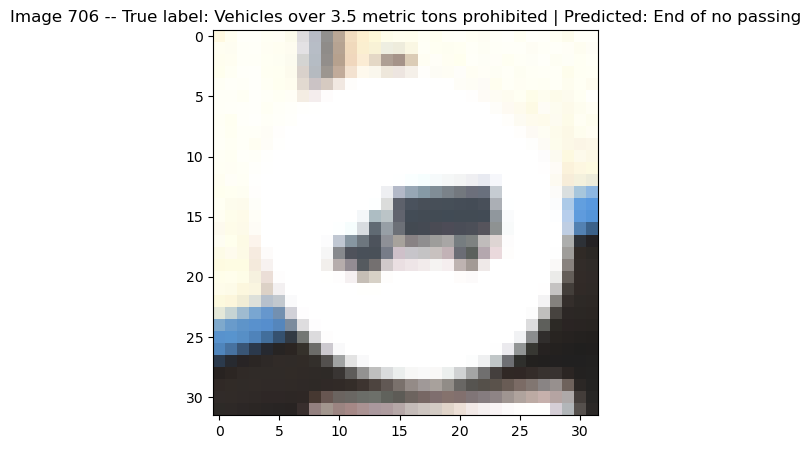

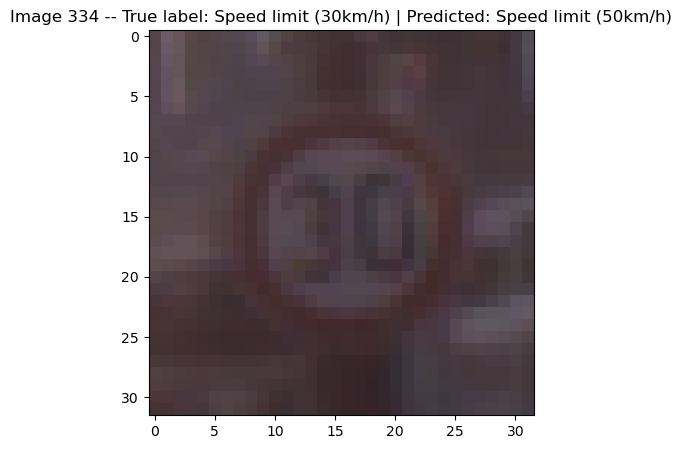

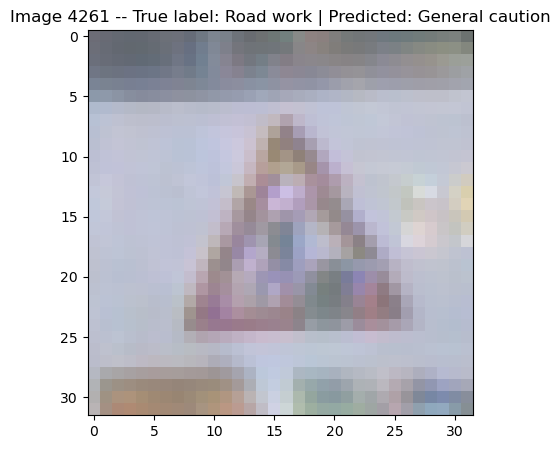

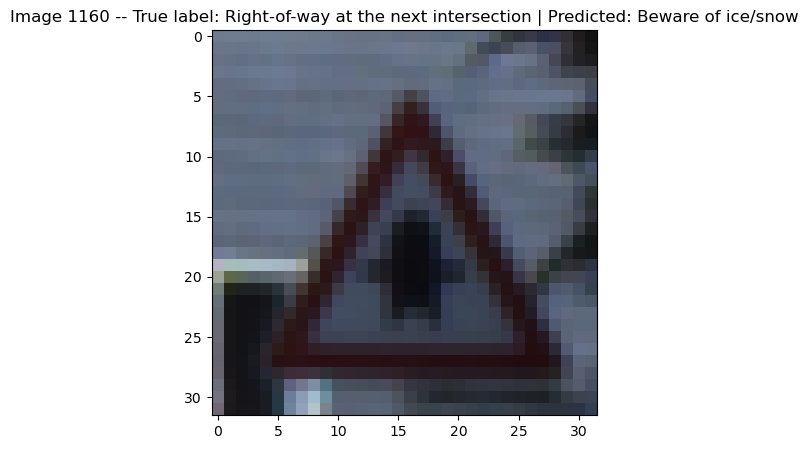

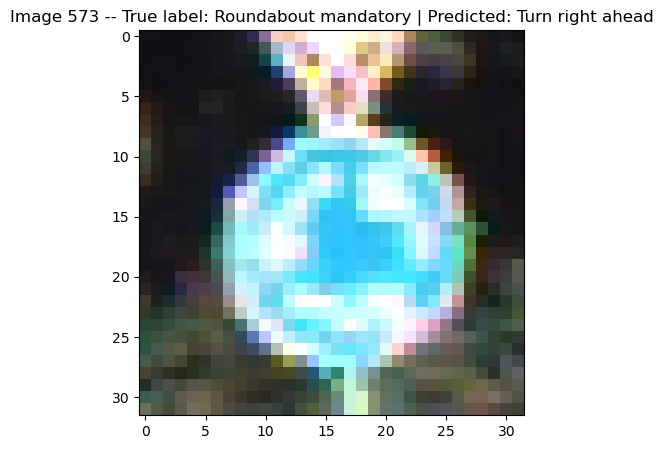

In [49]:
plot_misclassified_images(test_images_Pt, test_labels, predictions_cnn, signnames)

### Misclassified Images for `lenet5_regularized_dropout`

Index of misclassied image: 618
Index of misclassied image: 782
Index of misclassied image: 2143
Index of misclassied image: 4102
Index of misclassied image: 923


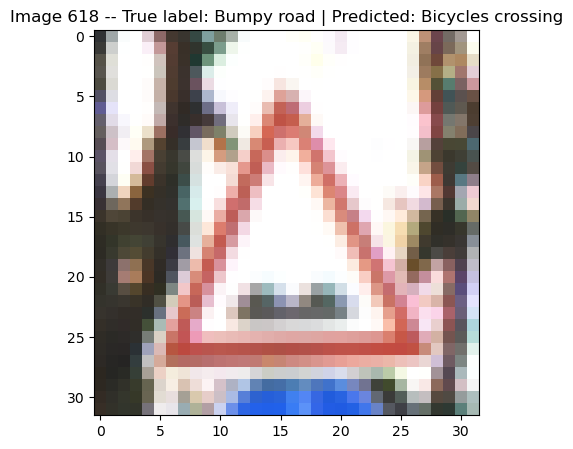

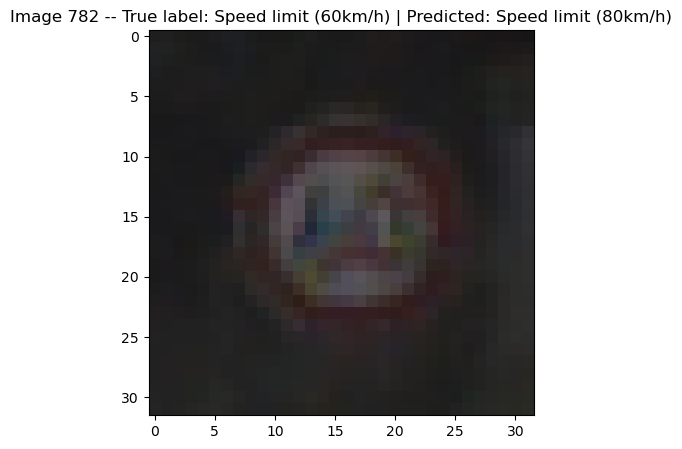

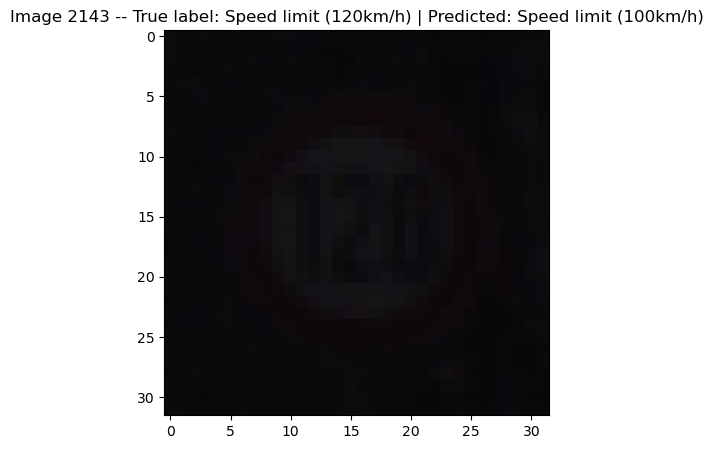

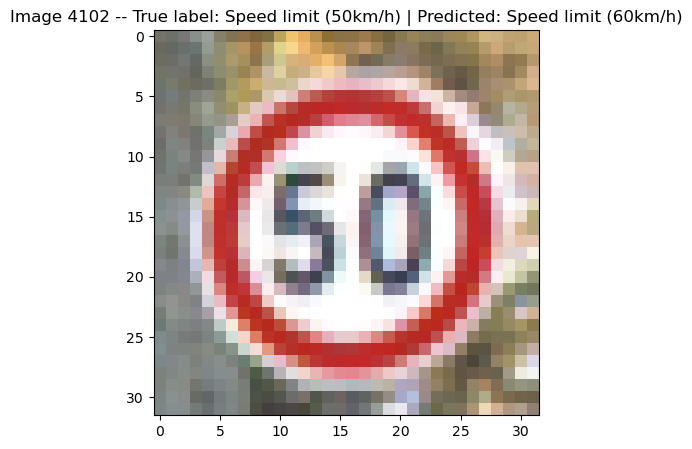

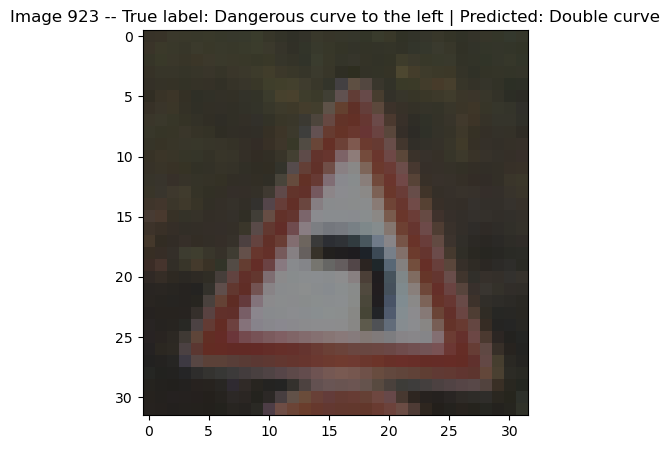

In [50]:
plot_misclassified_images(test_images_Pt, test_labels, predictions_lenet, signnames)

It is not surprising that our models misclassified **some** of these images as they are quite noisy and hard to see.
We can get a better idea of what our model is getting wrong by looking at the activation heatmap for each model.

## Activation Heatmap

> An activation heatmap, often implemented using Grad-CAM (Gradient-weighted Class Activation Mapping), is a visualization technique that highlights the important regions in an input image that contribute the most to the predictions made by a convolutional neural network (CNN).[[6](https://www.youtube.com/watch?v=VmbBnSv3otc)]

In the class below, we can create an activation heatmap for any image in our dataset. This code was adapted from [this](https://github.com/wiqaaas/youtube/blob/master/Deep_Learning_Using_Tensorflow/Demystifying_CNN/Gradient%20Visualization.ipynb) example. [7]

In [51]:
class GradCAM:
    def __init__(self, model, classId, layerName=None):
        self.model = model
        self.classId = classId
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output] # find output and the gradients
        )
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classId]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) # equivalent to np.dot
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.9, overlay_alpha=0.55,
        colormap=cv2.COLORMAP_JET):

        # apply the supplied color map to the heatmap and then1
        heatmap = cv2.applyColorMap(heatmap, colormap)   

        # check to see if image
        # convert image to 0 -> 255
        image = (image * 255).astype("uint8")

        # specifiy the output array type (must be explicitly specified in function 'arithm_op')
        # https://stackoverflow.com/questions/37198898/opencv-python-typeerror-src-data-type-16-is-not-supported
        output = cv2.addWeighted(image, alpha, heatmap, overlay_alpha, 0, dtype=cv2.CV_8U)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

`TBI: The below functions can be integrated into our GradCam model for efficiency.`

First we must expand the dimensions of our image to match the dimensions of our model.

We will use two images that were misclassified by our models
1. `142 - Go Straight or Right` (misclassified from our `cnn_regularized_dropout` model)
2. `1342 - Speed Limit 20km/h` (misclassified from our `lenet5_regularized_dropout` model)

In [52]:
'''
Please change the index of a and b to see the heatmap of different images.
'''

#a = 142
# correctly classified for cnn a = 4103
#a = 229
#a = 4103
#b = 347
a = 142
b = 1342

print(f"Shape of test_images_{a} before expanded dimensions: ", test_images_Pt[a].shape)
print(f"Shape of test_images_{b} before expanded dimensions: ", test_images_Pt[b].shape)

test_image_a = np.expand_dims(test_images_Pt[a], axis=0)
test_image_b = np.expand_dims(test_images_Pt[b], axis=0)

print("Shape of test_images_142 after expanded dimensions: ", test_image_a.shape)
print("Shape of test_images_1342 after expanded dimensions: ", test_image_b.shape)

Shape of test_images_142 before expanded dimensions:  (32, 32, 3)
Shape of test_images_1342 before expanded dimensions:  (32, 32, 3)
Shape of test_images_142 after expanded dimensions:  (1, 32, 32, 3)
Shape of test_images_1342 after expanded dimensions:  (1, 32, 32, 3)


Now we must get the predicted class for each image, for each model.

In [53]:
def get_prediction_metrics(model, test_image, test_label, signnames):
    '''
    This function takes in a model, test image, test label, and signnames dictionary.
    It returns the predictions, index of the prediction, label of the prediction,
    accuracy of the prediction, and the true label.
    '''
    predictions = model.predict(test_image)
    i_pred = np.argmax(predictions[0])
    label_pred = signnames[i_pred]
    pred_accuracy = predictions[0][i_pred]
    true_label = signnames[test_label]

    print("True label: {} | Predicted: {} | Accuracy: {:.2f}%".format(true_label, label_pred, pred_accuracy*100))

    return predictions, i_pred, label_pred, pred_accuracy, true_label

In [54]:
print(f"CNN Model Predictions for Image {a}")
cnn_predictions_i, i_cnn_predictions_a, label_cnn_predictions_a, pred_accuracy_cnn_a, true_label_a = \
    get_prediction_metrics(cnn_regularized_dropout, test_image_a, test_labels[a], signnames)

print(f"\nLeNet Model Predictions for Image {a}")
lenet_predictions_a, i_lenet_predictions_a, label_lenet_predictions_a, pred_accuracy_lenet_a, true_label_a = \
    get_prediction_metrics(lenet_regularized_dropout, test_image_a, test_labels[a], signnames)

print(f"\nCNN Model Predictions for Image {b}")
cnn_predictions_b, i_cnn_predictions_b, label_cnn_predictions_b, pred_accuracy_cnn_b, true_label_b = \
    get_prediction_metrics(cnn_regularized_dropout, test_image_b, test_labels[b], signnames)

print(f"\nLeNet Model Predictions for Image {b}")
lenet_predictions_b, i_lenet_predictions_b, label_lenet_predictions_b, pred_accuracy_lenet_b, true_label_b = \
    get_prediction_metrics(lenet_regularized_dropout, test_image_b, test_labels[b], signnames)

CNN Model Predictions for Image 142
True label: Go straight or right | Predicted: Roundabout mandatory | Accuracy: 44.96%

LeNet Model Predictions for Image 142
True label: Go straight or right | Predicted: Go straight or right | Accuracy: 96.37%

CNN Model Predictions for Image 1342
True label: Speed limit (20km/h) | Predicted: Speed limit (20km/h) | Accuracy: 99.30%

LeNet Model Predictions for Image 1342
True label: Speed limit (20km/h) | Predicted: Speed limit (70km/h) | Accuracy: 92.26%


* We can see that our `lenet5_regularized_dropout` model is predicting `image 142` accurately, but our `cnn_regularized_dropout` model is not.
* We can see that our `cnn_regularized_dropout` model is predicting `image 1342` accurately, but our `lenet5_regularized_dropout` model is not.


We can now plot the activation heatmap for each image, for each model.

In [55]:
def plot_activation_heatmap(cam, image, label, pred_label, pred_prob):
    """
    Plots the activation heatmap for a given image and the corresponding overlay
    Args:
        cam: the class activation map object
        heatmap: the heatmap to plot
        image: the image to plot
        label: the true label of the image
        pred_label: the predicted label of the image
        pred_prob: the probability of the predicted label
        overlay_alpha: the alpha value for the heatmap overlay
    
    Returns:
        None - plots the image, heatmap and overlay
    """
    # compute the heatmap for the image
    heatmap = cam.compute_heatmap(image)
    image = image.squeeze()
    # overlap the heatmap onto the image
    (heatmap, overlay) = cam.overlay_heatmap(heatmap, image)

    # plot the original image and the three heat map methods
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title("Original")
    axs[1].imshow(heatmap)
    axs[1].set_title("Heatmap")
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    fig.suptitle("True label: {} - Predicted label: {} - Probability: {:.2f}%".format(label, pred_label, pred_prob * 100))
    plt.show()

We have to chose a layer to visualize. Each layer will show different features of the image that the model is using to make its prediction. Here's a quick summary of what each layer will show [6]:
* *Layer 1*: Will show simple lines and edges in the images
* *Layer 2*: Will show more complex shapes
* *Layer 3*: Will show even more complex shapes that are not distinguishable by the human-eye, but are meaningful to the machine / model

Let's remind ourselves of the layers in our models.

In [56]:
cnn_regularized_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                73792     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [57]:
lenet_regularized_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 120)         48120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 120)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)              

For both models, we will use layer 1 as it is the most interpretable layer for humans.

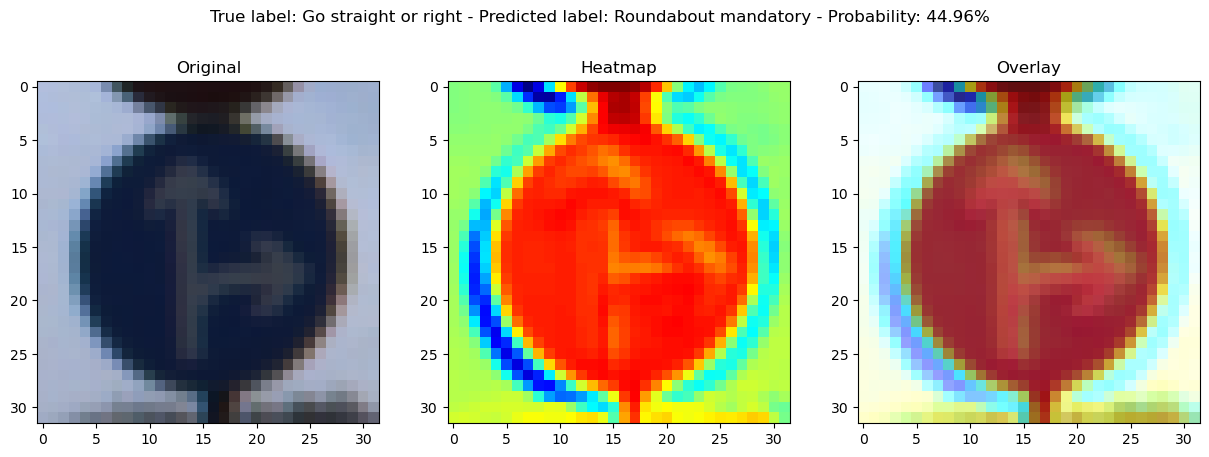

In [58]:
cam_cnn_a = GradCAM(cnn_regularized_dropout, i_cnn_predictions_a, layerName="conv2d_2")
plot_activation_heatmap(cam_cnn_a, test_image_a, true_label_a, label_cnn_predictions_a, pred_accuracy_cnn_a)

From the above activation heatmap, it can be seen that at the first layer on the CNN model, it is able to pick up on the edges of the traffic sign, however it does not have a strong activation for the arrows within the sign itself.

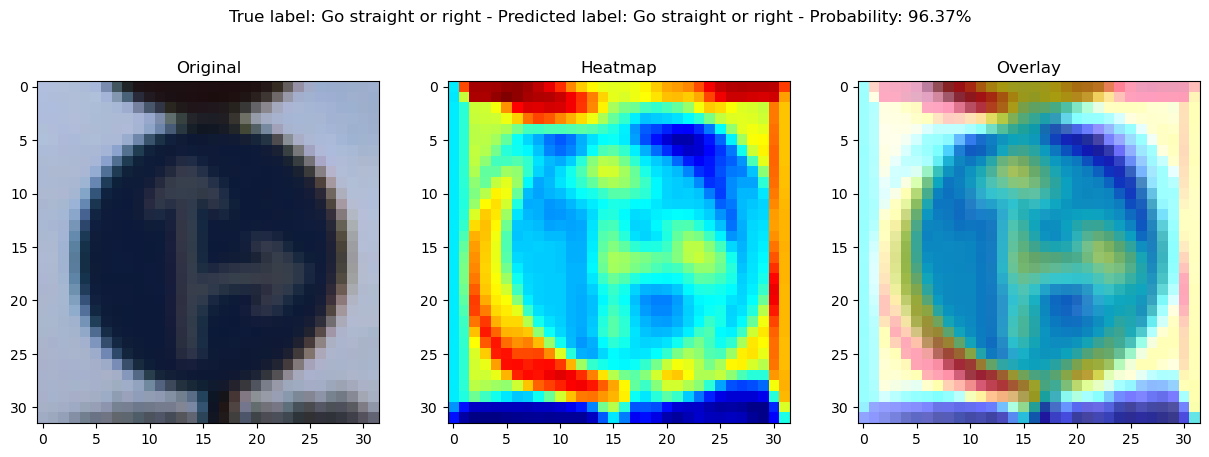

In [59]:
cam_lenet_a = GradCAM(lenet_regularized_dropout, i_lenet_predictions_a, layerName="conv2d_7")
plot_activation_heatmap(cam_lenet_a, test_image_a, true_label_a, label_lenet_predictions_a, pred_accuracy_lenet_a)

At the first layer of the LeNet5 model, it is able to pick up on both the edges of the traffic sign and the arrows within the sign itself. This makes sense as why it was able to predict the correct class for `image 142`.

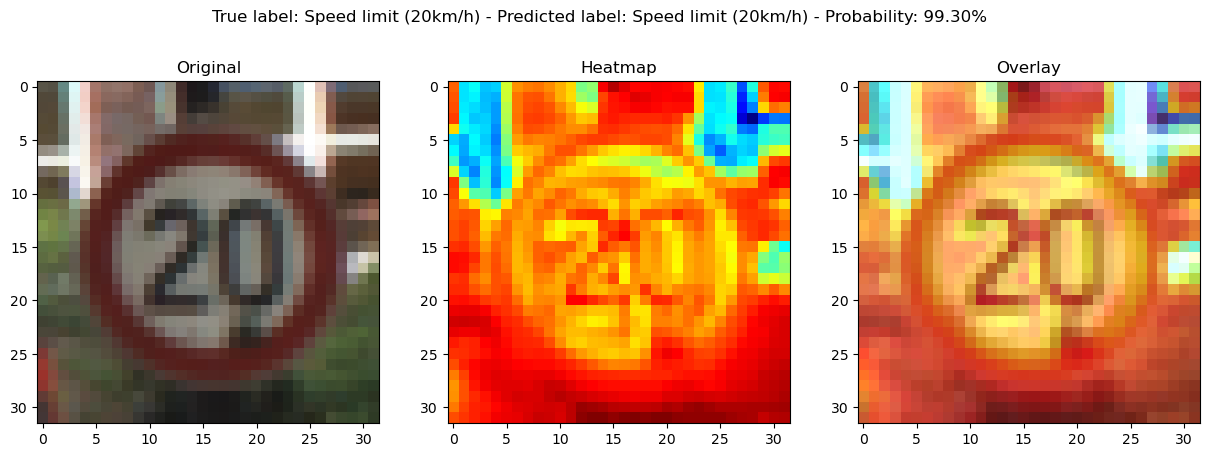

In [60]:
cam_cnn_b = GradCAM(cnn_regularized_dropout, i_cnn_predictions_b, layerName="conv2d_2")
plot_activation_heatmap(cam_cnn_b, test_image_b, true_label_b, label_cnn_predictions_b, pred_accuracy_cnn_b)

At the first layer of our CNN model for `image 1342`, it is able to pick up on the edges of the traffic sign as well as the edges of the number 20 within the sign. It makes sense as why it was able to predict the correct class for `image 1342` with such strong probability.

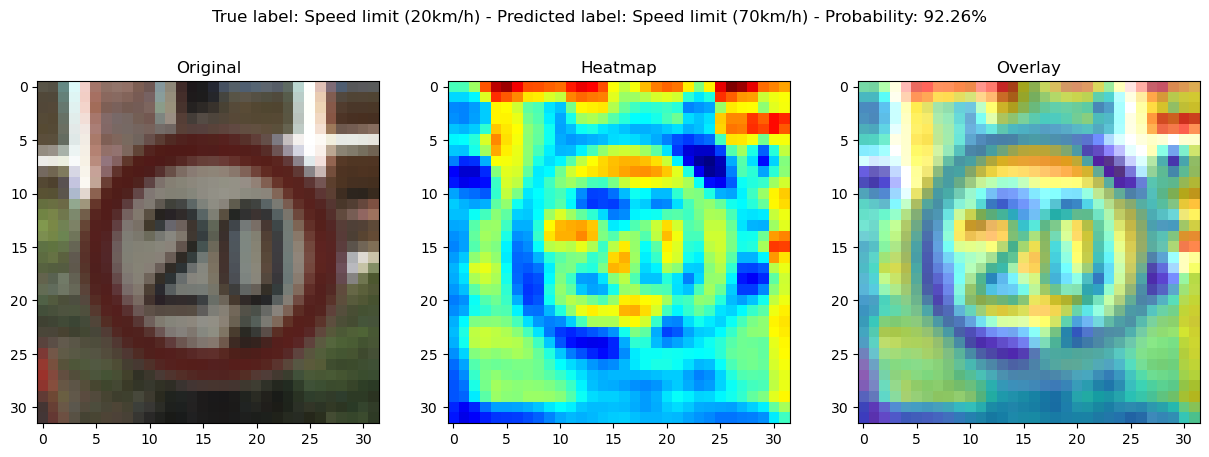

In [61]:
cam_lenet_b = GradCAM(lenet_regularized_dropout, i_lenet_predictions_b, layerName="conv2d_7")
plot_activation_heatmap(cam_lenet_b, test_image_b, true_label_b, label_lenet_predictions_b, pred_accuracy_lenet_b)

At the first layer of our LeNet5 model, it is able to pick up on the edges of the traffic sign, but it is not able to pick up on the edges of the number 20 within the sign. This makes sense as why it was not able to predict the correct class for `image 1342`.

For fun, and further exploration, we can take a look at the activation heatmap for the second layer and third layers of our LeNet5 model.

**Second Layer--**

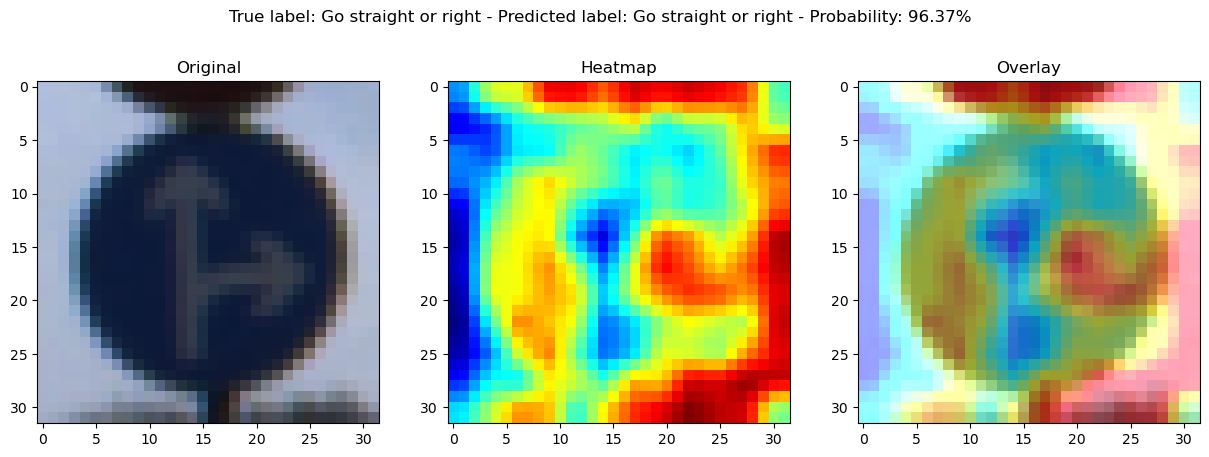

In [64]:
cam_lenet_a = GradCAM(lenet_regularized_dropout, i_lenet_predictions_a, layerName="conv2d_8")
plot_activation_heatmap(cam_lenet_a, test_image_a, true_label_a, label_lenet_predictions_a, pred_accuracy_lenet_a)

At the second layer of our LeNet5 model, we are able to see it now picks up on shapes. It identifies the sign as a circle, and the arrows within the sign (strong activation on the upwards arrow).

**Third Layer--**

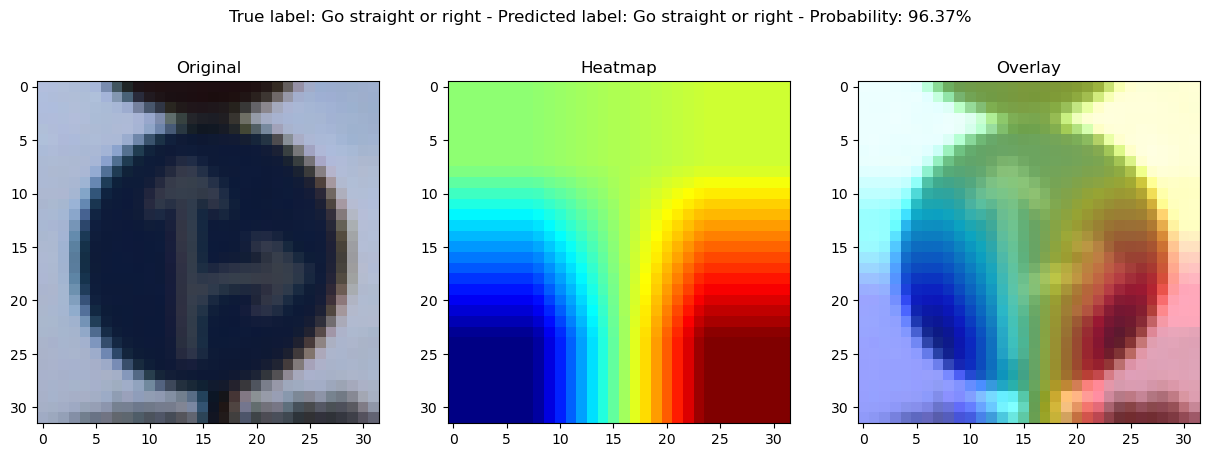

In [66]:
cam_lenet_a = GradCAM(lenet_regularized_dropout, i_lenet_predictions_a, layerName="conv2d_9")
plot_activation_heatmap(cam_lenet_a, test_image_a, true_label_a, label_lenet_predictions_a, pred_accuracy_lenet_a)

By the third layer of our LeNet5 model, we are no longer able to interpret what the model is picking up on by the human-eye, but these are the features that the model has broken to being the most important to make its prediction.

# Conclusion

We have successfully trained two models to classify traffic signs. We have also evaluated our models on the test set and visualized what our models are getting wrong.

Our `cnn_regularized_dropout` model has a test accuracy of ~90% and our `lenet5_regularized_dropout` model has a test accuracy of ~89%. (Model performance to vary by a few percentage points each time the model is trained due to the random initialization of the weights.)

Keep in mind, that these accuracy scores are not high enough to be used in a real world applications. We would have to further tune our models to get a higher accuracy score.

## Resources

Below are a list of resources used to develop this code along with some additional resources for further reading to learn more about CNNs.

1. [Convolutional Layers for Deep Learning Neural Networks](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

2. [Comprehensive Guide to Convolutional Neural Networks](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/)

3. [Complete Guide to Prevent Overfitting in Neural Networks (Part 1)](https://www.analyticsvidhya.com/blog/2021/06/complete-guide-to-prevent-overfitting-in-neural-networks-part-1/)

4. [Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

5. [The Architecture and Implementation of LeNet-5](https://towardsai.net/p/deep-learning/the-architecture-and-implementation-of-lenet-5)

6. [Explaining CNNs: Class Attribution Map Methods](https://arxiv.org/abs/1711.07658)

7. [Gradient Visualization in CNNs](https://github.com/wiqaaas/youtube/blob/master/Deep_Learning_Using_Tensorflow/Demystifying_CNN/Gradient%20Visualization.ipynb)


One great way to visualize CNNs can be found at this [link](https://adamharley.com/nn_vis/cnn/2d.html).

Further videos that do a great job explaing Class Activation Maps:
1. [Deep Learning: Class Activation Maps Theory](https://www.youtube.com/watch?v=vTY58-51XZA)
2. [Gradient Classification Activation Maps for Visualizing Convoluational Neural Networks in Tensorflow](https://www.youtube.com/watch?v=FjZpjMyQCu8)
